# The StakeholderEngagement ABM, follows my CitizenEngagement ABM in a social network context. 

The engagement and the social status parameters of the citizen engagement model are refurbished in 5 parameters: engagement, trustability, influenceability, recovery and experience. 

#### Values for each stakeholder category are calculated from a combination of variables in the data integration notebook. 
At the model creation, it is possible to select manually the average number of connection between nodes. A way to simulate different city scenarios: 
- Taipei : 1.90
- Tel Aviv : 2.10
- Tallinn : 2.20

## there are two steps in the model
- network setup (links are created between nodes depending on number of nodes and average number of connections between them).
- opinion formation of neutral nodes under the influence of stakeholders (-1: very negative / 1: very positive)

In [6]:
# import environment
import pandas as pd
import numpy as np
import random
import math
from enum import Enum

import networkx as nx

# modelling
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid

# data collection
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner

# visualisation window
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.UserParam import UserSettableParameter
from mesa.visualization.modules import ChartModule
from mesa.visualization.modules import NetworkModule
from mesa.visualization.modules import TextElement

# notebook visualisation
import matplotlib.pyplot as plt
%matplotlib inline

# agent.py

In [7]:
class Agent(Agent):
    # a member of the general population
    def __init__(
        self,
        unique_id,
        model,
        engagement, # network activity
        trustability, # influence limitation
        influenceability, # sensitivity to neighbors opinion
        recovery, # capacity to recover its initial opinion
        experience, # gain experience at each recovery
        initial_opinion, # defined manually through interface
        # independent variable
        opinion # y-axis to test
    ):
        super().__init__(unique_id, model)
        self.engagement = engagement
        self.trustability = trustability
        self.influenceability = influenceability
        self.recovery = recovery
        self.experience = experience
        self.initial_opinion = initial_opinion
        self.opinion = initial_opinion
     
    def step(self):
        # determine what agents do at each step:   
        self.check_neighbors()
        self.try_to_influence()
        self.recover()
    
    def check_neighbors(self):
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        self.neutral_neighbors = [agent for agent in 
                             self.model.grid.get_cell_list_contents(neighbors_nodes)
                             if agent.opinion > -0.5 and agent.opinion < 0.5]
        self.positive_neighbors = [agent for agent in 
                             self.model.grid.get_cell_list_contents(neighbors_nodes)
                             if agent.opinion > 0.5]
        self.negative_neighbors = [agent for agent in 
                             self.model.grid.get_cell_list_contents(neighbors_nodes)
                             if agent.opinion < - 0.5]
   
    def try_to_influence(self):
        # if opinion positive or negative, try to influence neighbors
        # if neighbor neutral, influences
        # if neighbor agree, influences
        # if neighbor disagree, battle. 
        # the strongest influences, the weakest loses trustability
        # if tie, nothing happens.
        # when influences, wins engagement depending on others' influenceability
        if self.opinion <= -0.5: # negative
            for a in self.neutral_neighbors:
                a.opinion -= 0.1*self.trustability*self.engagement
                if self.opinion < -1:
                    self.opinion = -1
                self.engagement += 0.05 - (0.05*a.influenceability)
                if self.engagement > 10:
                    self.engagement = 10
            for a in self.negative_neighbors:
                a.opinion -= 0.1*self.trustability*self.engagement
                if self.opinion < -1:
                    self.opinion = -1
                self.engagement += 0.01 - (0.01*a.influenceability)
                if self.engagement > 10:
                    self.engagement = 10
            for a in self.positive_neighbors:
                if abs(self.opinion) - abs(a.opinion) > 0: # negative is stronger
                    a.opinion -= 0.1*self.trustability*self.engagement
                    if self.opinion < -1:
                        self.opinion = -1
                    self.engagement += 0.1 - (0.1*a.influenceability)
                    if self.engagement > 10:
                        self.engagement = 10
                if abs(self.opinion) - abs(a.opinion) < 0: # positive is stronger
                    self.opinion += 0.1*a.trustability*self.engagement
                    if self.opinion > 1:
                        self.opinion = 1
                    self.trustability -= 0.1
                    if self.trustability < 0.01:
                        self.trustability = 0.01
        if self.opinion >= 0.5: # positive
            for a in self.neutral_neighbors:
                a.opinion += 0.1*self.trustability*self.engagement
                if self.opinion > 1:
                    self.opinion = 1
                self.engagement += 0.05 - (0.05*a.influenceability)
                if self.engagement > 10:
                    self.engagement = 10
            for a in self.positive_neighbors:
                a.opinion += 0.1*self.trustability*self.engagement
                if self.opinion > 1:
                    self.opinion = 1
                self.engagement += 0.01 - (0.01*a.influenceability)
                if self.engagement > 10:
                    self.engagement = 10
            for a in self.negative_neighbors:
                if abs(self.opinion) - abs(a.opinion) > 0: # positive is stronger
                    a.opinion += 0.1*self.trustability*self.engagement
                    if self.opinion > 1:
                        self.opinion = 1
                    self.engagement += 0.1 - (0.1*a.influenceability)
                    if self.engagement > 10:
                        self.engagement = 10
                if abs(self.opinion) - abs(a.opinion) < 0: # negative is stronger
                    self.opinion -= 0.1*a.trustability*self.engagement
                    if self.opinion < -1:
                        self.opinion = -1
                    self.trustability -= 0.01
                    if self.trustability < 0.01:
                        self.trustability = 0.01
        
    def recover(self):
        # if opinion != initial opinion, recover depending on experience
        # when recover, gain experience depending on influenceability
        # the more influenceable, the less experience win
        if self.opinion != self.initial_opinion:
            self.opinion = self.opinion*self.recovery*self.experience
            self.experience += 0.1 - (0.1*self.influenceability)
            if self.experience > 1:
                self.experience = 1

# model.py

In [21]:
# datacollector functions
def num_negative(model):
    # return number of negative opinions
    num_negative = [a for a in model.schedule.agents if a.opinion < -0.5]
    return len(num_negative)

def num_neutral(model):
    # return number of neutral opinions
    num_neutral = [a for a in model.schedule.agents if a.opinion < 0.5 and a.opinion > -0.5]
    return len(num_neutral)

def num_positive(model):
    # return number of positive opinions
    num_positive = [a for a in model.schedule.agents if a.opinion > 0.5]
    return len(num_positive)

def total_engagement(model):
    # engagement level in the population
    agent_engagement = [a.engagement for a in model.schedule.agents]
    return sum(agent_engagement)

def total_trustability(model):
    # trustability level in the population
    agent_trustability = [a.trustability for a in model.schedule.agents]
    return sum(agent_trustability)

def total_recovery(model):
    # recovery level in the population
    agent_recovery = [a.recovery for a in model.schedule.agents]
    return sum(agent_recovery)

def total_experience(model):
    # experience level in the population
    agent_experience = [a.experience for a in model.schedule.agents]
    return sum(agent_experience)

def public_opinion(model):
    # orientation of the population
    agent_opinion = [a.opinion for a in model.schedule.agents]
    return sum(agent_opinion) / num_nodes

class SEmodel(Model):
    # manual model has parameters set by user interface
    def __init__(
        self,
        num_nodes = 100,
        avg_node_degree = 3,
        # taipei : 1.92
        # telaviv : 2.16
        # tallinn : 2.20,
        engagement = 0.49,
        trustability = 0.21,
        influenceability = 0.53,
        recovery = 0.63,
        experience = 0.1,
        initial_opinion = 0,
        opinion = 0,
        public_sector_opinion = 1,
        corpo_opinion = 1,
        startup_opinion = 1,
        academic_opinion = -1,
        civil_opinion = -1,
        media_opinion = -1
    ):
        # set network layout
        self.num_nodes = num_nodes
        prob = avg_node_degree / self.num_nodes
        self.G = nx.erdos_renyi_graph(n=self.num_nodes, p=prob)    
        # set space and time of the model
        self.grid = NetworkGrid(self.G)
        self.schedule = RandomActivation(self)
        # set model parameters
        self.engagement = engagement
        self.trustability = trustability
        self.influenceability = influenceability
        self.recovery = recovery
        self.experience = experience
        self.initial_opinion = initial_opinion
        self.opinion = initial_opinion
        self.public_sector_opinion = public_sector_opinion
        self.corpo_opinion = corpo_opinion
        self.startup_opinion = startup_opinion
        self.academic_opinion = academic_opinion
        self.civil_opinion = civil_opinion
        self.media_opinion = media_opinion
        # set data collection
        self.datacollector = DataCollector(
            model_reporters ={
                "Negative": num_negative,
                "Neutral": num_neutral,
                "Positive": num_positive,
                "Total Engagement": total_engagement,
                "Total Trustability": total_trustability,
                "Total Recovery": total_recovery,
                "Total Experience": total_experience,
            },
            agent_reporters ={'Opinion': 'opinion',
                              'Engagement': 'engagement',
                              'Trustability': 'trustability',
                              'Recovery': 'recovery',
                              'Experience': 'experience'
            }
        )
        
        # create agents with average parameters taken on #city tweets
        for i, node in enumerate(self.G.nodes()):
            a = Agent(i,
                      self,
                      self.engagement,
                      self.trustability,
                      self.influenceability,
                      self.recovery,
                      self.experience,
                      self.initial_opinion, # fixed by interface
                      self.opinion
                     )
            self.schedule.add(a)
            # add the undetermined agents to the network
            self.grid.place_agent(a, node)
                     
        # create 1 representative of each stakeholder category
        public_sector = self.random.sample(self.G.nodes(), 1)
        for a in self.grid.get_cell_list_contents(public_sector):
            a.engagement = 0.57
            a.trustability = 0.53
            a.influenceability = 0.59
            a.recovery = 0.70
            a.experience = 0.1
            a.initial_opinion = public_sector_opinion # fixed by interface
            a.opinion = a.initial_opinion 
        
        corporate = self.random.sample(self.G.nodes(), 1)
        for a in self.grid.get_cell_list_contents(corporate):
            a.engagement = 0.75
            a.trustability = 0.49
            a.influenceability = 0.68
            a.recovery = 0.73
            a.experience = 0.1
            a.initial_opinion = corpo_opinion # fixed by interface
            a.opinion = a.initial_opinion 
            
        startup = self.random.sample(self.G.nodes(), 1)
        for a in self.grid.get_cell_list_contents(startup):
            a.engagement = 0.69
            a.trustability = 0.29
            a.influenceability = 0.68
            a.recovery = 0.97
            a.experience = 0.1
            a.initial_opinion = startup_opinion # fixed by interface
            a.opinion = a.initial_opinion                   

        academic = self.random.sample(self.G.nodes(), 1)
        for a in self.grid.get_cell_list_contents(academic):
            a.engagement = 0.49
            a.trustability = 0.20
            a.influenceability = 0.65
            a.recovery = 0.75
            a.experience = 0.1
            a.initial_opinion = academic_opinion # fixed by interface  
            a.opinion = a.initial_opinion 
            
        civil = self.random.sample(self.G.nodes(), 1)
        for a in self.grid.get_cell_list_contents(civil):
            a.engagement = 0.43
            a.trustability = 0.21
            a.influenceability = 0.69
            a.recovery = 0.72
            a.experience = 0.1
            a.initial_opinion = civil_opinion # fixed by interface
            a.opinion = a.initial_opinion 
            
        media = self.random.sample(self.G.nodes(), 1)
        for a in self.grid.get_cell_list_contents(media):
            a.engagement = 0.50
            a.trustability = 0.23
            a.influenceability = 0.65
            a.recovery = 0.71
            a.experience = 0.1
            a.initial_opinion = media_opinion # fixed by interface  
            a.opinion = a.initial_opinion 

        self.running = True
        self.datacollector.collect(self)
        print('Finished initialising model, network has %s nodes'%self.G.nodes)
        nx.draw_networkx(self.G)
        plt.show()
        
        
    def positive_negative_ratio(self):
        try:
            return num_positive(self) / num_negative(self)
        except ZeroDivisionError:
            return 0.00
        
    def step(self):
        # advance the model by one step and collect data
        self.schedule.step()
        # collect data
        self.datacollector.collect(self)
        
    def run_model(self, n):
        for i in range(n):
            self.step()

# server.py

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


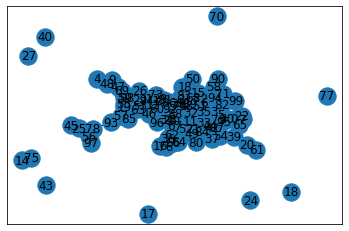

In [9]:
# red
negative_color = "#FF0000"
# grey
neutral_color = "#808080"
# positive
positive_color = "#0400ff"

def network_portrayal(G):
    # the model ensures that there is always 1 agent per node
    
    def node_color(agent):
        if agent.opinion > 0.5:
            return positive_color
        if agent.opinion < -0.5:
            return negative_color
        return neutral_color
    
    def edge_color(agent1, agent2):
        if (agent1.opinion > 0.5 and agent2.opinion > 0.5):
            return positive_color
        if (agent1.opinion < -0.5 and agent2.opinion < -0.5):
            return negative_color
        return neutral_color
    
    def edge_width(agent1, agent2):
        if (agent1.opinion > 0.5 and agent2.opinion > 0.5):
            return 3
        if (agent1.opinion > 0.5 and agent2.opinion > 0.5):
            return 3
        return 2
    
    def get_edges(source, target):
        return G.nodes[source]["agent"][0], G.nodes[target]["agent"][0]
    
    portrayal = dict()
    portrayal["nodes"] = [
        {
            "size": 6,
            "color": node_color(agents[0]),
            "tooltip": "id: {}<br>opinion: {}".format(
                agents[0].unique_id, agents[0].opinion
            )
        }
        for (_, agents) in G.nodes.data("agent")
    ]
    
    portrayal["edges"] = [
        {
            "source": source,
            "target": target,
            "color": edge_color(*get_edges(source, target)),
            "width": edge_width(*get_edges(source, target))
        }
        for (source, target) in G.edges
    ]
    
    return portrayal

# instantiate network module
network = NetworkModule(network_portrayal, 500, 500, library="d3")

# map data to chart in the ChartModule
chart = ChartModule(
    [
        {"Label": "Neutral", 'Color': neutral_color},
        {"Label": "Negative", 'Color': negative_color},
        {"Label": "Positive", 'Color': positive_color}
    ]
)

class MyTextElement(TextElement):
    def render(self, model):
        ratio = model.positive_negative_ratio()
        ratio_text = "&infin;" if ratio is math.inf else "{0:.2f}".format(ratio)
        positive_text = str(num_positive(model))
        negative_text = str(num_negative(model))

        return "Positive/Negative Ratio: {}<br>Positive Opinion: {}<br>Negative Opinion: {}".format(
            ratio_text, positive_text, negative_text
        )
    

# model parameters settable from interface
model_parameters = {
    "num_nodes": UserSettableParameter(
        "slider",
        "Number of nodes",
        100,
        10,
        1000,
        10,
        description="Number of nodes to include in the model"
    ),
    "avg_node_degree": UserSettableParameter(
        "slider", 
        "Average node degree", 
        2, 
        1, 
        5, 
        0.1, 
        description="Average number of links from each node"
    ),
    "initial_opinion": UserSettableParameter(
        "slider", 
        "Initial opinion of undetermined nodes", 
        0, 
        -1, 
        1, 
        0.1, 
        description="Opinion of the undetermined population."
    ),
    "public_sector_opinion": UserSettableParameter(
        "slider", 
        "Public sector opinion", 
        0, 
        -1, 
        1, 
        0.1, 
        description="Opinion of public sector stakeholder."
    ),
    "corpo_opinion": UserSettableParameter(
        "slider", 
        "Corporate companies opinion", 
        0, 
        -1, 
        1, 
        0.1, 
        description="Opinion of corporate companies stakeholder."
    ),
    "startup_opinion": UserSettableParameter(
        "slider", 
        "Startup business opinion", 
        0, 
        -1, 
        1, 
        0.1, 
        description="Opinion of startup business stakeholder."
    ),
    "academic_opinion": UserSettableParameter(
        "slider", 
        "Academic sector opinion", 
        0, 
        -1, 
        1, 
        0.1, 
        description="Opinion of academic sector stakeholder."
    ),
    "civil_opinion": UserSettableParameter(
        "slider", 
        "Civil society opinion", 
        0, 
        -1, 
        1, 
        0.1, 
        description="Opinion of civil society stakeholder."
    ),
    "media_opinion": UserSettableParameter(
        "slider", 
        "Media industry opinion", 
        0, 
        -1, 
        1, 
        0.1, 
        description="Opinion of media industry stakeholder."
    )
}

# create server
server = ModularServer(
    SEmodel, [network, MyTextElement(), chart], "Stakeholder Engagement Model", model_parameters
)
server.port = 8524 #default port

# run.py

Interface starting at http://127.0.0.1:8524


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}
Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


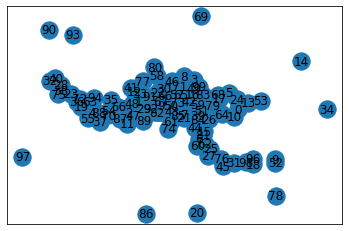

{"type":"submit_params","param":"public_sector_opinion","value":-1}
{"type":"submit_params","param":"corpo_opinion","value":-1}
{"type":"submit_params","param":"startup_opinion","value":-1}
{"type":"submit_params","param":"academic_opinion","value":1}
{"type":"submit_params","param":"civil_opinion","value":1}
{"type":"submit_params","param":"media_opinion","value":1}
{"type":"reset"}
Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


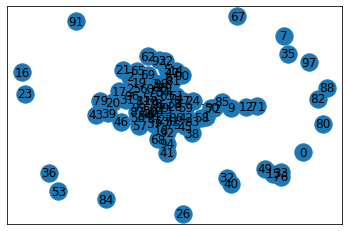

{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step":32}
{"type":"get_step","step":33}
{"type":"get_step",

{"type":"get_step","step":270}
{"type":"get_step","step":271}
{"type":"get_step","step":272}
{"type":"get_step","step":273}
{"type":"get_step","step":274}
{"type":"get_step","step":275}
{"type":"get_step","step":276}
{"type":"get_step","step":277}
{"type":"get_step","step":278}
{"type":"get_step","step":279}
{"type":"get_step","step":280}
{"type":"get_step","step":281}
{"type":"get_step","step":282}
{"type":"get_step","step":283}
{"type":"get_step","step":284}
{"type":"get_step","step":285}
{"type":"get_step","step":286}
{"type":"get_step","step":287}
{"type":"get_step","step":288}
{"type":"get_step","step":289}
{"type":"get_step","step":290}
{"type":"get_step","step":291}
{"type":"get_step","step":292}
{"type":"get_step","step":293}
{"type":"get_step","step":294}
{"type":"get_step","step":295}
{"type":"get_step","step":296}
{"type":"get_step","step":297}
{"type":"get_step","step":298}
{"type":"get_step","step":299}
{"type":"get_step","step":300}
{"type":"get_step","step":301}
{"type":

{"type":"get_step","step":535}
{"type":"get_step","step":536}
{"type":"get_step","step":537}
{"type":"get_step","step":538}
{"type":"get_step","step":539}
{"type":"get_step","step":540}
{"type":"get_step","step":541}
{"type":"get_step","step":542}
{"type":"get_step","step":543}
{"type":"get_step","step":544}
{"type":"get_step","step":545}
{"type":"get_step","step":546}
{"type":"get_step","step":547}
{"type":"get_step","step":548}
{"type":"get_step","step":549}
{"type":"get_step","step":550}
{"type":"get_step","step":551}
{"type":"get_step","step":552}
{"type":"get_step","step":553}
{"type":"get_step","step":554}
{"type":"get_step","step":555}
{"type":"get_step","step":556}
{"type":"get_step","step":557}
{"type":"get_step","step":558}
{"type":"get_step","step":559}
{"type":"get_step","step":560}
{"type":"get_step","step":561}
{"type":"get_step","step":562}
{"type":"get_step","step":563}
{"type":"get_step","step":564}
{"type":"get_step","step":565}
{"type":"get_step","step":566}
{"type":

{"type":"get_step","step":800}
{"type":"get_step","step":801}
{"type":"get_step","step":802}
{"type":"get_step","step":803}
{"type":"get_step","step":804}
{"type":"get_step","step":805}
{"type":"get_step","step":806}
{"type":"get_step","step":807}
{"type":"get_step","step":808}
{"type":"get_step","step":809}
{"type":"get_step","step":810}
{"type":"get_step","step":811}
{"type":"get_step","step":812}
{"type":"get_step","step":813}
{"type":"get_step","step":814}
{"type":"get_step","step":815}
{"type":"get_step","step":816}
{"type":"get_step","step":817}
{"type":"get_step","step":818}
{"type":"get_step","step":819}
{"type":"get_step","step":820}
{"type":"get_step","step":821}
{"type":"get_step","step":822}
{"type":"get_step","step":823}
{"type":"get_step","step":824}
{"type":"get_step","step":825}
{"type":"get_step","step":826}
{"type":"get_step","step":827}
{"type":"get_step","step":828}
{"type":"get_step","step":829}
{"type":"get_step","step":830}
{"type":"get_step","step":831}
{"type":

{"type":"get_step","step":1063}
{"type":"get_step","step":1064}
{"type":"get_step","step":1065}
{"type":"get_step","step":1066}
{"type":"get_step","step":1067}
{"type":"get_step","step":1068}
{"type":"get_step","step":1069}
{"type":"get_step","step":1070}
{"type":"get_step","step":1071}
{"type":"get_step","step":1072}
{"type":"get_step","step":1073}
{"type":"get_step","step":1074}
{"type":"get_step","step":1075}
{"type":"get_step","step":1076}
{"type":"get_step","step":1077}
{"type":"get_step","step":1078}
{"type":"get_step","step":1079}
{"type":"get_step","step":1080}
{"type":"get_step","step":1081}
{"type":"get_step","step":1082}
{"type":"get_step","step":1083}
{"type":"get_step","step":1084}
{"type":"get_step","step":1085}
{"type":"get_step","step":1086}
{"type":"get_step","step":1087}
{"type":"get_step","step":1088}
{"type":"get_step","step":1089}
{"type":"get_step","step":1090}
{"type":"get_step","step":1091}
{"type":"get_step","step":1092}
{"type":"get_step","step":1093}
{"type":

{"type":"get_step","step":1320}
{"type":"get_step","step":1321}
{"type":"get_step","step":1322}
{"type":"get_step","step":1323}
{"type":"get_step","step":1324}
{"type":"get_step","step":1325}
{"type":"get_step","step":1326}
{"type":"get_step","step":1327}
{"type":"get_step","step":1328}
{"type":"get_step","step":1329}
{"type":"get_step","step":1330}
{"type":"get_step","step":1331}
{"type":"get_step","step":1332}
{"type":"get_step","step":1333}
{"type":"get_step","step":1334}
{"type":"get_step","step":1335}
{"type":"get_step","step":1336}
{"type":"get_step","step":1337}
{"type":"get_step","step":1338}
{"type":"get_step","step":1339}
{"type":"get_step","step":1340}
{"type":"get_step","step":1341}
{"type":"get_step","step":1342}
{"type":"get_step","step":1343}
{"type":"get_step","step":1344}
{"type":"get_step","step":1345}
{"type":"get_step","step":1346}
{"type":"get_step","step":1347}
{"type":"get_step","step":1348}
{"type":"get_step","step":1349}
{"type":"get_step","step":1350}
{"type":

{"type":"get_step","step":1577}
{"type":"get_step","step":1578}
{"type":"get_step","step":1579}
{"type":"get_step","step":1580}
{"type":"get_step","step":1581}
{"type":"get_step","step":1582}
{"type":"get_step","step":1583}
{"type":"get_step","step":1584}
{"type":"get_step","step":1585}
{"type":"get_step","step":1586}
{"type":"get_step","step":1587}
{"type":"get_step","step":1588}
{"type":"get_step","step":1589}
{"type":"get_step","step":1590}
{"type":"get_step","step":1591}
{"type":"get_step","step":1592}
{"type":"get_step","step":1593}
{"type":"get_step","step":1594}
{"type":"get_step","step":1595}
{"type":"get_step","step":1596}
{"type":"get_step","step":1597}
{"type":"get_step","step":1598}
{"type":"get_step","step":1599}
{"type":"get_step","step":1600}
{"type":"get_step","step":1601}
{"type":"get_step","step":1602}
{"type":"get_step","step":1603}
{"type":"get_step","step":1604}
{"type":"get_step","step":1605}
{"type":"get_step","step":1606}
{"type":"get_step","step":1607}
{"type":

{"type":"get_step","step":1834}
{"type":"get_step","step":1835}
{"type":"get_step","step":1836}
{"type":"get_step","step":1837}
{"type":"get_step","step":1838}
{"type":"get_step","step":1839}
{"type":"get_step","step":1840}
{"type":"get_step","step":1841}
{"type":"get_step","step":1842}
{"type":"get_step","step":1843}
{"type":"get_step","step":1844}
{"type":"get_step","step":1845}
{"type":"get_step","step":1846}
{"type":"get_step","step":1847}
{"type":"get_step","step":1848}
{"type":"get_step","step":1849}
{"type":"get_step","step":1850}
{"type":"get_step","step":1851}
{"type":"get_step","step":1852}
{"type":"get_step","step":1853}
{"type":"get_step","step":1854}
{"type":"get_step","step":1855}
{"type":"get_step","step":1856}
{"type":"get_step","step":1857}
{"type":"get_step","step":1858}
{"type":"get_step","step":1859}
{"type":"get_step","step":1860}
{"type":"get_step","step":1861}
{"type":"get_step","step":1862}
{"type":"get_step","step":1863}
{"type":"get_step","step":1864}
{"type":

{"type":"get_step","step":2091}
{"type":"get_step","step":2092}
{"type":"get_step","step":2093}
{"type":"get_step","step":2094}
{"type":"get_step","step":2095}
{"type":"get_step","step":2096}
{"type":"get_step","step":2097}
{"type":"get_step","step":2098}
{"type":"get_step","step":2099}
{"type":"get_step","step":2100}
{"type":"get_step","step":2101}
{"type":"get_step","step":2102}
{"type":"get_step","step":2103}
{"type":"get_step","step":2104}
{"type":"get_step","step":2105}
{"type":"get_step","step":2106}
{"type":"get_step","step":2107}
{"type":"get_step","step":2108}
{"type":"get_step","step":2109}
{"type":"get_step","step":2110}
{"type":"get_step","step":2111}
{"type":"get_step","step":2112}
{"type":"get_step","step":2113}
{"type":"get_step","step":2114}
{"type":"get_step","step":2115}
{"type":"get_step","step":2116}
{"type":"get_step","step":2117}
{"type":"get_step","step":2118}
{"type":"get_step","step":2119}
{"type":"get_step","step":2120}
{"type":"get_step","step":2121}
{"type":

{"type":"get_step","step":2348}
{"type":"get_step","step":2349}
{"type":"get_step","step":2350}
{"type":"get_step","step":2351}
{"type":"get_step","step":2352}
{"type":"get_step","step":2353}
{"type":"get_step","step":2354}
{"type":"get_step","step":2355}
{"type":"get_step","step":2356}
{"type":"get_step","step":2357}
{"type":"get_step","step":2358}
{"type":"get_step","step":2359}
{"type":"get_step","step":2360}
{"type":"get_step","step":2361}
{"type":"get_step","step":2362}
{"type":"get_step","step":2363}
{"type":"get_step","step":2364}
{"type":"get_step","step":2365}
{"type":"get_step","step":2366}
{"type":"get_step","step":2367}
{"type":"get_step","step":2368}
{"type":"get_step","step":2369}
{"type":"get_step","step":2370}
{"type":"get_step","step":2371}
{"type":"get_step","step":2372}
{"type":"get_step","step":2373}
{"type":"get_step","step":2374}
{"type":"get_step","step":2375}
{"type":"get_step","step":2376}
{"type":"get_step","step":2377}
{"type":"get_step","step":2378}
{"type":

{"type":"get_step","step":2605}
{"type":"get_step","step":2606}
{"type":"get_step","step":2607}
{"type":"get_step","step":2608}
{"type":"get_step","step":2609}
{"type":"get_step","step":2610}
{"type":"get_step","step":2611}
{"type":"get_step","step":2612}
{"type":"get_step","step":2613}
{"type":"get_step","step":2614}
{"type":"get_step","step":2615}
{"type":"get_step","step":2616}
{"type":"get_step","step":2617}
{"type":"get_step","step":2618}
{"type":"get_step","step":2619}
{"type":"get_step","step":2620}
{"type":"get_step","step":2621}
{"type":"get_step","step":2622}
{"type":"get_step","step":2623}
{"type":"get_step","step":2624}
{"type":"get_step","step":2625}
{"type":"get_step","step":2626}
{"type":"get_step","step":2627}
{"type":"get_step","step":2628}
{"type":"get_step","step":2629}
{"type":"get_step","step":2630}
{"type":"get_step","step":2631}
{"type":"get_step","step":2632}
{"type":"get_step","step":2633}
{"type":"get_step","step":2634}
{"type":"get_step","step":2635}
{"type":

{"type":"get_step","step":2862}
{"type":"get_step","step":2863}
{"type":"get_step","step":2864}
{"type":"get_step","step":2865}
{"type":"get_step","step":2866}
{"type":"get_step","step":2867}
{"type":"get_step","step":2868}
{"type":"get_step","step":2869}
{"type":"get_step","step":2870}
{"type":"get_step","step":2871}
{"type":"get_step","step":2872}
{"type":"get_step","step":2873}
{"type":"get_step","step":2874}
{"type":"get_step","step":2875}
{"type":"get_step","step":2876}
{"type":"get_step","step":2877}
{"type":"get_step","step":2878}
{"type":"get_step","step":2879}
{"type":"get_step","step":2880}
{"type":"get_step","step":2881}
{"type":"get_step","step":2882}
{"type":"get_step","step":2883}
{"type":"get_step","step":2884}
{"type":"get_step","step":2885}
{"type":"get_step","step":2886}
{"type":"get_step","step":2887}
{"type":"get_step","step":2888}
{"type":"get_step","step":2889}
{"type":"get_step","step":2890}
{"type":"get_step","step":2891}
{"type":"get_step","step":2892}
{"type":

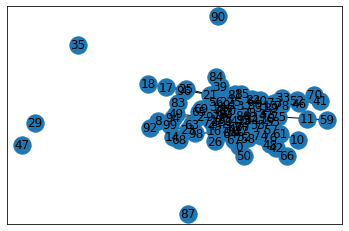

{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step":32}
{"type":"get_step","step":33}
{"type":"get_step",

{"type":"get_step","step":270}
{"type":"get_step","step":271}
{"type":"get_step","step":272}
{"type":"get_step","step":273}
{"type":"get_step","step":274}
{"type":"get_step","step":275}
{"type":"get_step","step":276}
{"type":"get_step","step":277}
{"type":"get_step","step":278}
{"type":"get_step","step":279}
{"type":"get_step","step":280}
{"type":"get_step","step":281}
{"type":"get_step","step":282}
{"type":"get_step","step":283}
{"type":"get_step","step":284}
{"type":"get_step","step":285}
{"type":"get_step","step":286}
{"type":"get_step","step":287}
{"type":"get_step","step":288}
{"type":"get_step","step":289}
{"type":"get_step","step":290}
{"type":"get_step","step":291}
{"type":"get_step","step":292}
{"type":"get_step","step":293}
{"type":"get_step","step":294}
{"type":"get_step","step":295}
{"type":"get_step","step":296}
{"type":"get_step","step":297}
{"type":"get_step","step":298}
{"type":"get_step","step":299}
{"type":"get_step","step":300}
{"type":"get_step","step":301}
{"type":

{"type":"get_step","step":535}
{"type":"get_step","step":536}
{"type":"get_step","step":537}
{"type":"get_step","step":538}
{"type":"get_step","step":539}
{"type":"get_step","step":540}
{"type":"get_step","step":541}
{"type":"get_step","step":542}
{"type":"get_step","step":543}
{"type":"get_step","step":544}
{"type":"get_step","step":545}
{"type":"get_step","step":546}
{"type":"get_step","step":547}
{"type":"get_step","step":548}
{"type":"get_step","step":549}
{"type":"get_step","step":550}
{"type":"get_step","step":551}
{"type":"get_step","step":552}
{"type":"get_step","step":553}
{"type":"get_step","step":554}
{"type":"get_step","step":555}
{"type":"get_step","step":556}
{"type":"get_step","step":557}
{"type":"get_step","step":558}
{"type":"get_step","step":559}
{"type":"get_step","step":560}
{"type":"get_step","step":561}
{"type":"get_step","step":562}
{"type":"get_step","step":563}
{"type":"get_step","step":564}
{"type":"get_step","step":565}
{"type":"get_step","step":566}
{"type":

{"type":"get_step","step":800}
{"type":"get_step","step":801}
{"type":"get_step","step":802}
{"type":"get_step","step":803}
{"type":"get_step","step":804}
{"type":"get_step","step":805}
{"type":"get_step","step":806}
{"type":"get_step","step":807}
{"type":"get_step","step":808}
{"type":"get_step","step":809}
{"type":"get_step","step":810}
{"type":"get_step","step":811}
{"type":"get_step","step":812}
{"type":"get_step","step":813}
{"type":"get_step","step":814}
{"type":"get_step","step":815}
{"type":"get_step","step":816}
{"type":"get_step","step":817}
{"type":"get_step","step":818}
{"type":"get_step","step":819}
{"type":"get_step","step":820}
{"type":"get_step","step":821}
{"type":"get_step","step":822}
{"type":"get_step","step":823}
{"type":"get_step","step":824}
{"type":"get_step","step":825}
{"type":"get_step","step":826}
{"type":"get_step","step":827}
{"type":"get_step","step":828}
{"type":"get_step","step":829}
{"type":"get_step","step":830}
{"type":"get_step","step":831}
{"type":

{"type":"get_step","step":1063}
{"type":"get_step","step":1064}
{"type":"get_step","step":1065}
{"type":"get_step","step":1066}
{"type":"get_step","step":1067}
{"type":"get_step","step":1068}
{"type":"get_step","step":1069}
{"type":"get_step","step":1070}
{"type":"get_step","step":1071}
{"type":"get_step","step":1072}
{"type":"get_step","step":1073}
{"type":"get_step","step":1074}
{"type":"get_step","step":1075}
{"type":"get_step","step":1076}
{"type":"get_step","step":1077}
{"type":"get_step","step":1078}
{"type":"get_step","step":1079}
{"type":"get_step","step":1080}
{"type":"get_step","step":1081}
{"type":"get_step","step":1082}
{"type":"get_step","step":1083}
{"type":"get_step","step":1084}
{"type":"get_step","step":1085}
{"type":"get_step","step":1086}
{"type":"get_step","step":1087}
{"type":"get_step","step":1088}
{"type":"get_step","step":1089}
{"type":"get_step","step":1090}
{"type":"get_step","step":1091}
{"type":"get_step","step":1092}
{"type":"get_step","step":1093}
{"type":

{"type":"get_step","step":1320}
{"type":"get_step","step":1321}
{"type":"get_step","step":1322}
{"type":"get_step","step":1323}
{"type":"get_step","step":1324}
{"type":"get_step","step":1325}
{"type":"get_step","step":1326}
{"type":"get_step","step":1327}
{"type":"get_step","step":1328}
{"type":"get_step","step":1329}
{"type":"get_step","step":1330}
{"type":"get_step","step":1331}
{"type":"get_step","step":1332}
{"type":"get_step","step":1333}
{"type":"get_step","step":1334}
{"type":"get_step","step":1335}
{"type":"get_step","step":1336}
{"type":"get_step","step":1337}
{"type":"get_step","step":1338}
{"type":"get_step","step":1339}
{"type":"get_step","step":1340}
{"type":"get_step","step":1341}
{"type":"get_step","step":1342}
{"type":"get_step","step":1343}
{"type":"get_step","step":1344}
{"type":"get_step","step":1345}
{"type":"get_step","step":1346}
{"type":"get_step","step":1347}
{"type":"get_step","step":1348}
{"type":"get_step","step":1349}
{"type":"get_step","step":1350}
{"type":

{"type":"get_step","step":1577}
{"type":"get_step","step":1578}
{"type":"get_step","step":1579}
{"type":"get_step","step":1580}
{"type":"get_step","step":1581}
{"type":"get_step","step":1582}
{"type":"get_step","step":1583}
{"type":"get_step","step":1584}
{"type":"get_step","step":1585}
{"type":"get_step","step":1586}
{"type":"get_step","step":1587}
{"type":"get_step","step":1588}
{"type":"get_step","step":1589}
{"type":"get_step","step":1590}
{"type":"get_step","step":1591}
{"type":"get_step","step":1592}
{"type":"get_step","step":1593}
{"type":"get_step","step":1594}
{"type":"get_step","step":1595}
{"type":"get_step","step":1596}
{"type":"get_step","step":1597}
{"type":"get_step","step":1598}
{"type":"get_step","step":1599}
{"type":"get_step","step":1600}
{"type":"get_step","step":1601}
{"type":"get_step","step":1602}
{"type":"get_step","step":1603}
{"type":"get_step","step":1604}
{"type":"get_step","step":1605}
{"type":"get_step","step":1606}
{"type":"get_step","step":1607}
{"type":

{"type":"get_step","step":1834}
{"type":"get_step","step":1835}
{"type":"get_step","step":1836}
{"type":"get_step","step":1837}
{"type":"get_step","step":1838}
{"type":"get_step","step":1839}
{"type":"get_step","step":1840}
{"type":"get_step","step":1841}
{"type":"get_step","step":1842}
{"type":"get_step","step":1843}
{"type":"get_step","step":1844}
{"type":"get_step","step":1845}
{"type":"get_step","step":1846}
{"type":"get_step","step":1847}
{"type":"get_step","step":1848}
{"type":"get_step","step":1849}
{"type":"get_step","step":1850}
{"type":"get_step","step":1851}
{"type":"get_step","step":1852}
{"type":"get_step","step":1853}
{"type":"get_step","step":1854}
{"type":"get_step","step":1855}
{"type":"get_step","step":1856}
{"type":"get_step","step":1857}
{"type":"get_step","step":1858}
{"type":"get_step","step":1859}
{"type":"get_step","step":1860}
{"type":"get_step","step":1861}
{"type":"get_step","step":1862}
{"type":"get_step","step":1863}
{"type":"get_step","step":1864}
{"type":

{"type":"get_step","step":2091}
{"type":"get_step","step":2092}
{"type":"get_step","step":2093}
{"type":"get_step","step":2094}
{"type":"get_step","step":2095}
{"type":"get_step","step":2096}
{"type":"get_step","step":2097}
{"type":"get_step","step":2098}
{"type":"get_step","step":2099}
{"type":"get_step","step":2100}
{"type":"get_step","step":2101}
{"type":"get_step","step":2102}
{"type":"get_step","step":2103}
{"type":"get_step","step":2104}
{"type":"get_step","step":2105}
{"type":"get_step","step":2106}
{"type":"get_step","step":2107}
{"type":"get_step","step":2108}
{"type":"get_step","step":2109}
{"type":"get_step","step":2110}
{"type":"get_step","step":2111}
{"type":"get_step","step":2112}
{"type":"get_step","step":2113}
{"type":"get_step","step":2114}
{"type":"get_step","step":2115}
{"type":"get_step","step":2116}
{"type":"get_step","step":2117}
{"type":"get_step","step":2118}
{"type":"get_step","step":2119}
{"type":"get_step","step":2120}
{"type":"get_step","step":2121}
{"type":

{"type":"get_step","step":2348}
{"type":"get_step","step":2349}
{"type":"get_step","step":2350}
{"type":"get_step","step":2351}
{"type":"get_step","step":2352}
{"type":"get_step","step":2353}
{"type":"get_step","step":2354}
{"type":"get_step","step":2355}
{"type":"get_step","step":2356}
{"type":"get_step","step":2357}
{"type":"get_step","step":2358}
{"type":"get_step","step":2359}
{"type":"get_step","step":2360}
{"type":"get_step","step":2361}
{"type":"get_step","step":2362}
{"type":"get_step","step":2363}
{"type":"get_step","step":2364}
{"type":"get_step","step":2365}
{"type":"get_step","step":2366}
{"type":"get_step","step":2367}
{"type":"get_step","step":2368}
{"type":"get_step","step":2369}
{"type":"get_step","step":2370}
{"type":"get_step","step":2371}
{"type":"get_step","step":2372}
{"type":"get_step","step":2373}
{"type":"get_step","step":2374}
{"type":"get_step","step":2375}
{"type":"get_step","step":2376}
{"type":"get_step","step":2377}
{"type":"get_step","step":2378}
{"type":

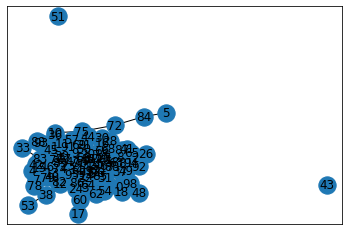

{"type":"reset"}
Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


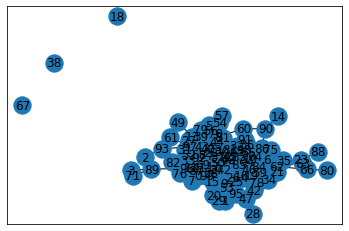

{"type":"reset"}
Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


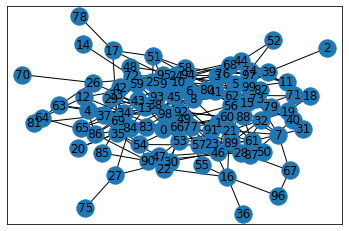

{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step":32}
{"type":"get_step","step":33}
{"type":"get_step",

{"type":"get_step","step":270}
{"type":"get_step","step":271}
{"type":"get_step","step":272}
{"type":"get_step","step":273}
{"type":"get_step","step":274}
{"type":"get_step","step":275}
{"type":"get_step","step":276}
{"type":"get_step","step":277}
{"type":"get_step","step":278}
{"type":"get_step","step":279}
{"type":"get_step","step":280}
{"type":"get_step","step":281}
{"type":"get_step","step":282}
{"type":"get_step","step":283}
{"type":"get_step","step":284}
{"type":"get_step","step":285}
{"type":"get_step","step":286}
{"type":"get_step","step":287}
{"type":"get_step","step":288}
{"type":"get_step","step":289}
{"type":"get_step","step":290}
{"type":"get_step","step":291}
{"type":"get_step","step":292}
{"type":"get_step","step":293}
{"type":"get_step","step":294}
{"type":"get_step","step":295}
{"type":"get_step","step":296}
{"type":"get_step","step":297}
{"type":"get_step","step":298}
{"type":"get_step","step":299}
{"type":"get_step","step":300}
{"type":"get_step","step":301}
{"type":

{"type":"get_step","step":535}
{"type":"get_step","step":536}
{"type":"get_step","step":537}
{"type":"get_step","step":538}
{"type":"get_step","step":539}
{"type":"get_step","step":540}
{"type":"get_step","step":541}
{"type":"get_step","step":542}
{"type":"get_step","step":543}
{"type":"get_step","step":544}
{"type":"get_step","step":545}
{"type":"get_step","step":546}
{"type":"get_step","step":547}
{"type":"get_step","step":548}
{"type":"get_step","step":549}
{"type":"get_step","step":550}
{"type":"get_step","step":551}
{"type":"get_step","step":552}
{"type":"get_step","step":553}
{"type":"get_step","step":554}
{"type":"get_step","step":555}
{"type":"get_step","step":556}
{"type":"get_step","step":557}
{"type":"get_step","step":558}
{"type":"get_step","step":559}
{"type":"get_step","step":560}
{"type":"get_step","step":561}
{"type":"get_step","step":562}
{"type":"get_step","step":563}
{"type":"get_step","step":564}
{"type":"get_step","step":565}
{"type":"get_step","step":566}
{"type":

{"type":"get_step","step":800}
{"type":"get_step","step":801}
{"type":"get_step","step":802}
{"type":"get_step","step":803}
{"type":"get_step","step":804}
{"type":"get_step","step":805}
{"type":"get_step","step":806}
{"type":"get_step","step":807}
{"type":"get_step","step":808}
{"type":"get_step","step":809}
{"type":"get_step","step":810}
{"type":"get_step","step":811}
{"type":"get_step","step":812}
{"type":"get_step","step":813}
{"type":"get_step","step":814}
{"type":"get_step","step":815}
{"type":"submit_params","param":"avg_node_degree","value":5}
{"type":"reset"}
Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98

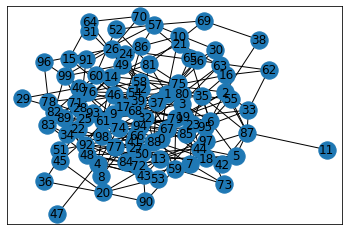

{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step":32}
{"type":"get_step","step":33}
{"type":"get_step",

{"type":"get_step","step":269}
{"type":"get_step","step":270}
{"type":"get_step","step":271}
{"type":"get_step","step":272}
{"type":"get_step","step":273}
{"type":"get_step","step":274}
{"type":"get_step","step":275}
{"type":"get_step","step":276}
{"type":"get_step","step":277}
{"type":"get_step","step":278}
{"type":"get_step","step":279}
{"type":"get_step","step":280}
{"type":"get_step","step":281}
{"type":"get_step","step":282}
{"type":"get_step","step":283}
{"type":"get_step","step":284}
{"type":"get_step","step":285}
{"type":"get_step","step":286}
{"type":"get_step","step":287}
{"type":"get_step","step":288}
{"type":"get_step","step":289}
{"type":"get_step","step":290}
{"type":"get_step","step":291}
{"type":"get_step","step":292}
{"type":"get_step","step":293}
{"type":"get_step","step":294}
{"type":"get_step","step":295}
{"type":"get_step","step":296}
{"type":"get_step","step":297}
{"type":"get_step","step":298}
{"type":"get_step","step":299}
{"type":"get_step","step":300}
{"type":

{"type":"get_step","step":534}
{"type":"get_step","step":535}
{"type":"get_step","step":536}
{"type":"get_step","step":537}
{"type":"get_step","step":538}
{"type":"get_step","step":539}
{"type":"get_step","step":540}
{"type":"get_step","step":541}
{"type":"get_step","step":542}
{"type":"get_step","step":543}
{"type":"get_step","step":544}
{"type":"get_step","step":545}
{"type":"get_step","step":546}
{"type":"get_step","step":547}
{"type":"get_step","step":548}
{"type":"get_step","step":549}
{"type":"get_step","step":550}
{"type":"get_step","step":551}
{"type":"get_step","step":552}
{"type":"get_step","step":553}
{"type":"get_step","step":554}
{"type":"get_step","step":555}
{"type":"get_step","step":556}
{"type":"get_step","step":557}
{"type":"get_step","step":558}
{"type":"get_step","step":559}
{"type":"get_step","step":560}
{"type":"get_step","step":561}
{"type":"get_step","step":562}
{"type":"get_step","step":563}
{"type":"get_step","step":564}
{"type":"get_step","step":565}
{"type":

{"type":"reset"}
Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


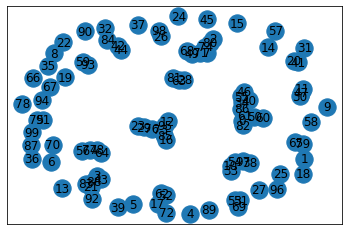

{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step":32}
{"type":"get_step","step":33}
{"type":"get_step",

{"type":"get_step","step":269}
{"type":"get_step","step":270}
{"type":"get_step","step":271}
{"type":"get_step","step":272}
{"type":"get_step","step":273}
{"type":"get_step","step":274}
{"type":"get_step","step":275}
{"type":"get_step","step":276}
{"type":"get_step","step":277}
{"type":"get_step","step":278}
{"type":"get_step","step":279}
{"type":"get_step","step":280}
{"type":"get_step","step":281}
{"type":"get_step","step":282}
{"type":"get_step","step":283}
{"type":"get_step","step":284}
{"type":"get_step","step":285}
{"type":"get_step","step":286}
{"type":"get_step","step":287}
{"type":"get_step","step":288}
{"type":"get_step","step":289}
{"type":"get_step","step":290}
{"type":"get_step","step":291}
{"type":"get_step","step":292}
{"type":"get_step","step":293}
{"type":"get_step","step":294}
{"type":"get_step","step":295}
{"type":"get_step","step":296}
{"type":"get_step","step":297}
{"type":"get_step","step":298}
{"type":"get_step","step":299}
{"type":"get_step","step":300}
{"type":

{"type":"get_step","step":535}
{"type":"get_step","step":536}
{"type":"get_step","step":537}
{"type":"get_step","step":538}
{"type":"get_step","step":539}
{"type":"get_step","step":540}
{"type":"get_step","step":541}
{"type":"get_step","step":542}
{"type":"get_step","step":543}
{"type":"get_step","step":544}
{"type":"get_step","step":545}
{"type":"get_step","step":546}
{"type":"get_step","step":547}
{"type":"get_step","step":548}
{"type":"get_step","step":549}
{"type":"get_step","step":550}
{"type":"get_step","step":551}
{"type":"get_step","step":552}
{"type":"get_step","step":553}
{"type":"get_step","step":554}
{"type":"get_step","step":555}
{"type":"get_step","step":556}
{"type":"get_step","step":557}
{"type":"get_step","step":558}
{"type":"get_step","step":559}
{"type":"get_step","step":560}
{"type":"get_step","step":561}
{"type":"get_step","step":562}
{"type":"get_step","step":563}
{"type":"get_step","step":564}
{"type":"get_step","step":565}
{"type":"get_step","step":566}
{"type":

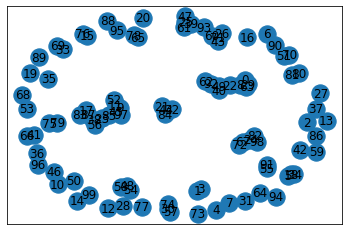

{"type":"submit_params","param":"avg_node_degree","value":1.7}
{"type":"submit_params","param":"avg_node_degree","value":2}
{"type":"submit_params","param":"avg_node_degree","value":3.1}
{"type":"submit_params","param":"avg_node_degree","value":3}
{"type":"reset"}
Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


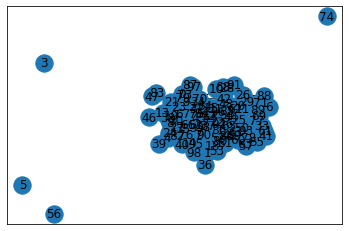

{"type":"submit_params","param":"avg_node_degree","value":5}
{"type":"reset"}
Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


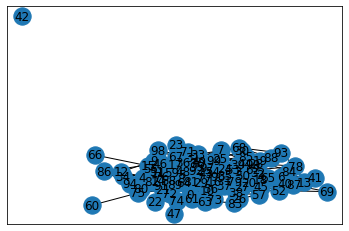

{"type":"submit_params","param":"public_sector_opinion","value":1}
{"type":"submit_params","param":"civil_opinion","value":-1}
{"type":"submit_params","param":"academic_opinion","value":-1}
{"type":"submit_params","param":"media_opinion","value":-1}
{"type":"submit_params","param":"public_sector_opinion","value":-1}
{"type":"submit_params","param":"public_sector_opinion","value":1}
{"type":"submit_params","param":"academic_opinion","value":1}
{"type":"submit_params","param":"civil_opinion","value":1}
{"type":"submit_params","param":"academic_opinion","value":-1}
{"type":"submit_params","param":"media_opinion","value":1}
{"type":"submit_params","param":"avg_node_degree","value":2.8}
{"type":"submit_params","param":"avg_node_degree","value":2.4}
{"type":"submit_params","param":"avg_node_degree","value":2.2}
{"type":"submit_params","param":"avg_node_degree","value":2}
{"type":"reset"}
Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1

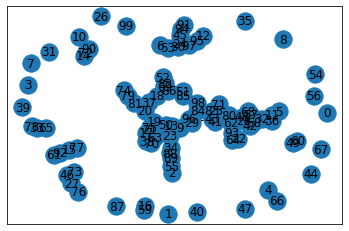

{"type":"reset"}
Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


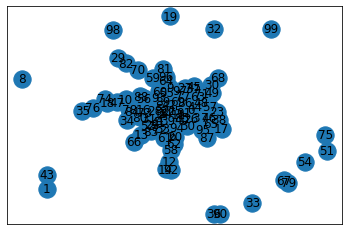

{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step":32}
{"type":"get_step","step":33}
{"type":"get_step",

{"type":"get_step","step":269}
{"type":"get_step","step":270}
{"type":"get_step","step":271}
{"type":"get_step","step":272}
{"type":"get_step","step":273}
{"type":"get_step","step":274}
{"type":"get_step","step":275}
{"type":"get_step","step":276}
{"type":"get_step","step":277}
{"type":"get_step","step":278}
{"type":"get_step","step":279}
{"type":"get_step","step":280}
{"type":"get_step","step":281}
{"type":"get_step","step":282}
{"type":"get_step","step":283}
{"type":"get_step","step":284}
{"type":"get_step","step":285}
{"type":"get_step","step":286}
{"type":"get_step","step":287}
{"type":"get_step","step":288}
{"type":"get_step","step":289}
{"type":"get_step","step":290}
{"type":"get_step","step":291}
{"type":"get_step","step":292}
{"type":"get_step","step":293}
{"type":"get_step","step":294}
{"type":"get_step","step":295}
{"type":"get_step","step":296}
{"type":"get_step","step":297}
{"type":"get_step","step":298}
{"type":"get_step","step":299}
{"type":"get_step","step":300}
{"type":

{"type":"get_step","step":534}
{"type":"get_step","step":535}
{"type":"get_step","step":536}
{"type":"get_step","step":537}
{"type":"get_step","step":538}
{"type":"get_step","step":539}
{"type":"get_step","step":540}
{"type":"get_step","step":541}
{"type":"get_step","step":542}
{"type":"get_step","step":543}
{"type":"get_step","step":544}
{"type":"get_step","step":545}
{"type":"get_step","step":546}
{"type":"get_step","step":547}
{"type":"get_step","step":548}
{"type":"get_step","step":549}
{"type":"get_step","step":550}
{"type":"get_step","step":551}
{"type":"get_step","step":552}
{"type":"get_step","step":553}
{"type":"get_step","step":554}
{"type":"get_step","step":555}
{"type":"get_step","step":556}
{"type":"get_step","step":557}
{"type":"get_step","step":558}
{"type":"get_step","step":559}
{"type":"get_step","step":560}
{"type":"get_step","step":561}
{"type":"get_step","step":562}
{"type":"get_step","step":563}
{"type":"get_step","step":564}
{"type":"get_step","step":565}
{"type":

{"type":"get_step","step":799}
{"type":"get_step","step":800}
{"type":"get_step","step":801}
{"type":"get_step","step":802}
{"type":"get_step","step":803}
{"type":"get_step","step":804}
{"type":"get_step","step":805}
{"type":"get_step","step":806}
{"type":"get_step","step":807}
{"type":"get_step","step":808}
{"type":"get_step","step":809}
{"type":"get_step","step":810}
{"type":"get_step","step":811}
{"type":"get_step","step":812}
{"type":"get_step","step":813}
{"type":"get_step","step":814}
{"type":"get_step","step":815}
{"type":"get_step","step":816}
{"type":"get_step","step":817}
{"type":"get_step","step":818}
{"type":"get_step","step":819}
{"type":"get_step","step":820}
{"type":"get_step","step":821}
{"type":"get_step","step":822}
{"type":"get_step","step":823}
{"type":"get_step","step":824}
{"type":"get_step","step":825}
{"type":"get_step","step":826}
{"type":"get_step","step":827}
{"type":"get_step","step":828}
{"type":"get_step","step":829}
{"type":"get_step","step":830}
{"type":

{"type":"get_step","step":1062}
{"type":"get_step","step":1063}
{"type":"get_step","step":1064}
{"type":"get_step","step":1065}
{"type":"get_step","step":1066}
{"type":"get_step","step":1067}
{"type":"get_step","step":1068}
{"type":"get_step","step":1069}
{"type":"get_step","step":1070}
{"type":"get_step","step":1071}
{"type":"get_step","step":1072}
{"type":"get_step","step":1073}
{"type":"get_step","step":1074}
{"type":"get_step","step":1075}
{"type":"get_step","step":1076}
{"type":"get_step","step":1077}
{"type":"get_step","step":1078}
{"type":"get_step","step":1079}
{"type":"get_step","step":1080}
{"type":"get_step","step":1081}
{"type":"get_step","step":1082}
{"type":"get_step","step":1083}
{"type":"get_step","step":1084}
{"type":"get_step","step":1085}
{"type":"get_step","step":1086}
{"type":"get_step","step":1087}
{"type":"get_step","step":1088}
{"type":"get_step","step":1089}
{"type":"get_step","step":1090}
{"type":"get_step","step":1091}
{"type":"get_step","step":1092}
{"type":

{"type":"get_step","step":1319}
{"type":"get_step","step":1320}
{"type":"get_step","step":1321}
{"type":"get_step","step":1322}
{"type":"get_step","step":1323}
{"type":"get_step","step":1324}
{"type":"get_step","step":1325}
{"type":"get_step","step":1326}
{"type":"get_step","step":1327}
{"type":"get_step","step":1328}
{"type":"get_step","step":1329}
{"type":"get_step","step":1330}
{"type":"get_step","step":1331}
{"type":"get_step","step":1332}
{"type":"get_step","step":1333}
{"type":"get_step","step":1334}
{"type":"get_step","step":1335}
{"type":"get_step","step":1336}
{"type":"get_step","step":1337}
{"type":"get_step","step":1338}
{"type":"get_step","step":1339}
{"type":"get_step","step":1340}
{"type":"get_step","step":1341}
{"type":"get_step","step":1342}
{"type":"get_step","step":1343}
{"type":"get_step","step":1344}
{"type":"get_step","step":1345}
{"type":"get_step","step":1346}
{"type":"get_step","step":1347}
{"type":"get_step","step":1348}
{"type":"get_step","step":1349}
{"type":

{"type":"get_step","step":1576}
{"type":"get_step","step":1577}
{"type":"get_step","step":1578}
{"type":"get_step","step":1579}
{"type":"get_step","step":1580}
{"type":"get_step","step":1581}
{"type":"get_step","step":1582}
{"type":"get_step","step":1583}
{"type":"get_step","step":1584}
{"type":"get_step","step":1585}
{"type":"get_step","step":1586}
{"type":"get_step","step":1587}
{"type":"get_step","step":1588}
{"type":"get_step","step":1589}
{"type":"get_step","step":1590}
{"type":"get_step","step":1591}
{"type":"get_step","step":1592}
{"type":"get_step","step":1593}
{"type":"get_step","step":1594}
{"type":"get_step","step":1595}
{"type":"get_step","step":1596}
{"type":"get_step","step":1597}
{"type":"get_step","step":1598}
{"type":"get_step","step":1599}
{"type":"get_step","step":1600}
{"type":"get_step","step":1601}
{"type":"get_step","step":1602}
{"type":"get_step","step":1603}
{"type":"get_step","step":1604}
{"type":"get_step","step":1605}
{"type":"get_step","step":1606}
{"type":

{"type":"get_step","step":1833}
{"type":"get_step","step":1834}
{"type":"get_step","step":1835}
{"type":"get_step","step":1836}
{"type":"get_step","step":1837}
{"type":"get_step","step":1838}
{"type":"get_step","step":1839}
{"type":"get_step","step":1840}
{"type":"get_step","step":1841}
{"type":"get_step","step":1842}
{"type":"get_step","step":1843}
{"type":"get_step","step":1844}
{"type":"get_step","step":1845}
{"type":"get_step","step":1846}
{"type":"get_step","step":1847}
{"type":"get_step","step":1848}
{"type":"get_step","step":1849}
{"type":"get_step","step":1850}
{"type":"get_step","step":1851}
{"type":"get_step","step":1852}
{"type":"get_step","step":1853}
{"type":"get_step","step":1854}
{"type":"get_step","step":1855}
{"type":"get_step","step":1856}
{"type":"get_step","step":1857}
{"type":"get_step","step":1858}
{"type":"get_step","step":1859}
{"type":"get_step","step":1860}
{"type":"get_step","step":1861}
{"type":"get_step","step":1862}
{"type":"get_step","step":1863}
{"type":

{"type":"get_step","step":2090}
{"type":"get_step","step":2091}
{"type":"get_step","step":2092}
{"type":"get_step","step":2093}
{"type":"get_step","step":2094}
{"type":"get_step","step":2095}
{"type":"get_step","step":2096}
{"type":"get_step","step":2097}
{"type":"get_step","step":2098}
{"type":"get_step","step":2099}
{"type":"get_step","step":2100}
{"type":"get_step","step":2101}
{"type":"get_step","step":2102}
{"type":"get_step","step":2103}
{"type":"get_step","step":2104}
{"type":"get_step","step":2105}
{"type":"get_step","step":2106}
{"type":"get_step","step":2107}
{"type":"get_step","step":2108}
{"type":"get_step","step":2109}
{"type":"get_step","step":2110}
{"type":"get_step","step":2111}
{"type":"get_step","step":2112}
{"type":"get_step","step":2113}
{"type":"get_step","step":2114}
{"type":"get_step","step":2115}
{"type":"get_step","step":2116}
{"type":"get_step","step":2117}
{"type":"get_step","step":2118}
{"type":"get_step","step":2119}
{"type":"get_step","step":2120}
{"type":

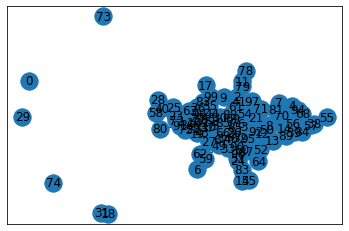

{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step":32}
{"type":"get_step","step":33}
{"type":"get_step",

{"type":"get_step","step":269}
{"type":"get_step","step":270}
{"type":"get_step","step":271}
{"type":"get_step","step":272}
{"type":"get_step","step":273}
{"type":"get_step","step":274}
{"type":"get_step","step":275}
{"type":"get_step","step":276}
{"type":"get_step","step":277}
{"type":"get_step","step":278}
{"type":"get_step","step":279}
{"type":"get_step","step":280}
{"type":"get_step","step":281}
{"type":"get_step","step":282}
{"type":"get_step","step":283}
{"type":"get_step","step":284}
{"type":"get_step","step":285}
{"type":"get_step","step":286}
{"type":"get_step","step":287}
{"type":"get_step","step":288}
{"type":"get_step","step":289}
{"type":"get_step","step":290}
{"type":"get_step","step":291}
{"type":"get_step","step":292}
{"type":"get_step","step":293}
{"type":"get_step","step":294}
{"type":"get_step","step":295}
{"type":"get_step","step":296}
{"type":"get_step","step":297}
{"type":"get_step","step":298}
{"type":"get_step","step":299}
{"type":"get_step","step":300}
{"type":

{"type":"get_step","step":534}
{"type":"get_step","step":535}
{"type":"get_step","step":536}
{"type":"get_step","step":537}
{"type":"get_step","step":538}
{"type":"get_step","step":539}
{"type":"get_step","step":540}
{"type":"get_step","step":541}
{"type":"get_step","step":542}
{"type":"get_step","step":543}
{"type":"get_step","step":544}
{"type":"get_step","step":545}
{"type":"get_step","step":546}
{"type":"get_step","step":547}
{"type":"get_step","step":548}
{"type":"get_step","step":549}
{"type":"get_step","step":550}
{"type":"get_step","step":551}
{"type":"get_step","step":552}
{"type":"get_step","step":553}
{"type":"get_step","step":554}
{"type":"get_step","step":555}
{"type":"get_step","step":556}
{"type":"get_step","step":557}
{"type":"get_step","step":558}
{"type":"get_step","step":559}
{"type":"get_step","step":560}
{"type":"get_step","step":561}
{"type":"get_step","step":562}
{"type":"get_step","step":563}
{"type":"get_step","step":564}
{"type":"get_step","step":565}
{"type":

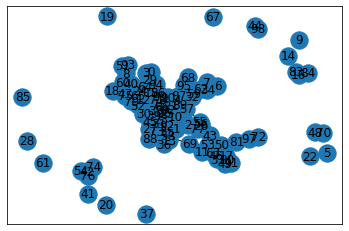

{"type":"reset"}
Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


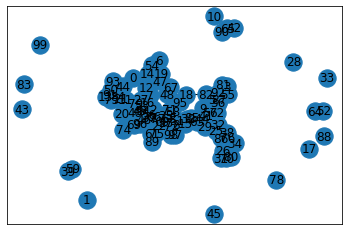

{"type":"reset"}
Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


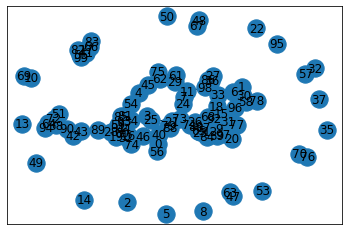

{"type":"reset"}
Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


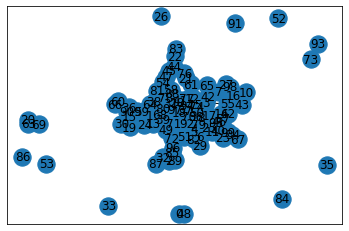

{"type":"reset"}
Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


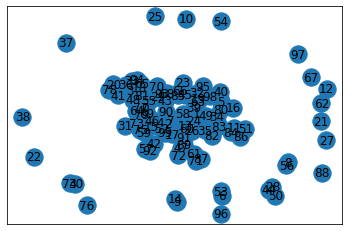

{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step":32}
{"type":"get_step","step":33}
{"type":"get_step",

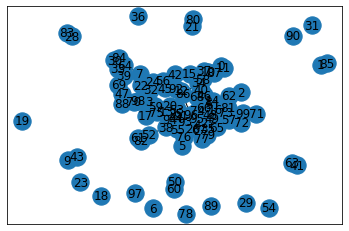

{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step":32}
{"type":"get_step","step":33}
{"type":"get_step",

{"type":"get_step","step":269}
{"type":"get_step","step":270}
{"type":"get_step","step":271}
{"type":"get_step","step":272}
{"type":"get_step","step":273}
{"type":"get_step","step":274}
{"type":"get_step","step":275}
{"type":"get_step","step":276}
{"type":"get_step","step":277}
{"type":"get_step","step":278}
{"type":"get_step","step":279}
{"type":"get_step","step":280}
{"type":"get_step","step":281}
{"type":"get_step","step":282}
{"type":"get_step","step":283}
{"type":"get_step","step":284}
{"type":"get_step","step":285}
{"type":"get_step","step":286}
{"type":"get_step","step":287}
{"type":"get_step","step":288}
{"type":"get_step","step":289}
{"type":"get_step","step":290}
{"type":"get_step","step":291}
{"type":"get_step","step":292}
{"type":"get_step","step":293}
{"type":"get_step","step":294}
{"type":"get_step","step":295}
{"type":"get_step","step":296}
{"type":"get_step","step":297}
{"type":"get_step","step":298}
{"type":"get_step","step":299}
{"type":"get_step","step":300}
{"type":

{"type":"get_step","step":535}
{"type":"get_step","step":536}
{"type":"get_step","step":537}
{"type":"get_step","step":538}
{"type":"get_step","step":539}
{"type":"get_step","step":540}
{"type":"get_step","step":541}
{"type":"get_step","step":542}
{"type":"get_step","step":543}
{"type":"get_step","step":544}
{"type":"get_step","step":545}
{"type":"get_step","step":546}
{"type":"get_step","step":547}
{"type":"get_step","step":548}
{"type":"get_step","step":549}
{"type":"get_step","step":550}
{"type":"get_step","step":551}
{"type":"get_step","step":552}
{"type":"get_step","step":553}
{"type":"get_step","step":554}
{"type":"get_step","step":555}
{"type":"get_step","step":556}
{"type":"get_step","step":557}
{"type":"get_step","step":558}
{"type":"get_step","step":559}
{"type":"get_step","step":560}
{"type":"get_step","step":561}
{"type":"get_step","step":562}
{"type":"get_step","step":563}
{"type":"get_step","step":564}
{"type":"get_step","step":565}
{"type":"get_step","step":566}
{"type":

{"type":"get_step","step":800}
{"type":"get_step","step":801}
{"type":"get_step","step":802}
{"type":"get_step","step":803}
{"type":"get_step","step":804}
{"type":"get_step","step":805}
{"type":"get_step","step":806}
{"type":"get_step","step":807}
{"type":"get_step","step":808}
{"type":"get_step","step":809}
{"type":"get_step","step":810}
{"type":"get_step","step":811}
{"type":"get_step","step":812}
{"type":"get_step","step":813}
{"type":"get_step","step":814}
{"type":"get_step","step":815}
{"type":"get_step","step":816}
{"type":"get_step","step":817}
{"type":"get_step","step":818}
{"type":"get_step","step":819}
{"type":"get_step","step":820}
{"type":"get_step","step":821}
{"type":"get_step","step":822}
{"type":"get_step","step":823}
{"type":"get_step","step":824}
{"type":"get_step","step":825}
{"type":"get_step","step":826}
{"type":"get_step","step":827}
{"type":"get_step","step":828}
{"type":"get_step","step":829}
{"type":"get_step","step":830}
{"type":"get_step","step":831}
{"type":

{"type":"get_step","step":1063}
{"type":"get_step","step":1064}
{"type":"get_step","step":1065}
{"type":"get_step","step":1066}
{"type":"get_step","step":1067}
{"type":"get_step","step":1068}
{"type":"get_step","step":1069}
{"type":"get_step","step":1070}
{"type":"get_step","step":1071}
{"type":"get_step","step":1072}
{"type":"get_step","step":1073}
{"type":"get_step","step":1074}
{"type":"get_step","step":1075}
{"type":"get_step","step":1076}
{"type":"get_step","step":1077}
{"type":"get_step","step":1078}
{"type":"get_step","step":1079}
{"type":"get_step","step":1080}
{"type":"get_step","step":1081}
{"type":"get_step","step":1082}
{"type":"get_step","step":1083}
{"type":"get_step","step":1084}
{"type":"get_step","step":1085}
{"type":"get_step","step":1086}
{"type":"get_step","step":1087}
{"type":"get_step","step":1088}
{"type":"get_step","step":1089}
{"type":"get_step","step":1090}
{"type":"get_step","step":1091}
{"type":"get_step","step":1092}
{"type":"get_step","step":1093}
{"type":

{"type":"get_step","step":1320}
{"type":"get_step","step":1321}
{"type":"get_step","step":1322}
{"type":"get_step","step":1323}
{"type":"get_step","step":1324}
{"type":"get_step","step":1325}
{"type":"get_step","step":1326}
{"type":"get_step","step":1327}
{"type":"get_step","step":1328}
{"type":"get_step","step":1329}
{"type":"get_step","step":1330}
{"type":"get_step","step":1331}
{"type":"get_step","step":1332}
{"type":"get_step","step":1333}
{"type":"get_step","step":1334}
{"type":"get_step","step":1335}
{"type":"get_step","step":1336}
{"type":"get_step","step":1337}
{"type":"get_step","step":1338}
{"type":"get_step","step":1339}
{"type":"get_step","step":1340}
{"type":"get_step","step":1341}
{"type":"get_step","step":1342}
{"type":"get_step","step":1343}
{"type":"get_step","step":1344}
{"type":"get_step","step":1345}
{"type":"get_step","step":1346}
{"type":"get_step","step":1347}
{"type":"get_step","step":1348}
{"type":"get_step","step":1349}
{"type":"get_step","step":1350}
{"type":

{"type":"get_step","step":1577}
{"type":"get_step","step":1578}
{"type":"get_step","step":1579}
{"type":"get_step","step":1580}
{"type":"get_step","step":1581}
{"type":"get_step","step":1582}
{"type":"get_step","step":1583}
{"type":"get_step","step":1584}
{"type":"get_step","step":1585}
{"type":"get_step","step":1586}
{"type":"get_step","step":1587}
{"type":"get_step","step":1588}
{"type":"get_step","step":1589}
{"type":"get_step","step":1590}
{"type":"get_step","step":1591}
{"type":"get_step","step":1592}
{"type":"get_step","step":1593}
{"type":"get_step","step":1594}
{"type":"get_step","step":1595}
{"type":"get_step","step":1596}
{"type":"get_step","step":1597}
{"type":"get_step","step":1598}
{"type":"get_step","step":1599}
{"type":"get_step","step":1600}
{"type":"get_step","step":1601}
{"type":"get_step","step":1602}
{"type":"get_step","step":1603}
{"type":"get_step","step":1604}
{"type":"get_step","step":1605}
{"type":"get_step","step":1606}
{"type":"get_step","step":1607}
{"type":

{"type":"get_step","step":1834}
{"type":"get_step","step":1835}
{"type":"get_step","step":1836}
{"type":"get_step","step":1837}
{"type":"get_step","step":1838}
{"type":"get_step","step":1839}
{"type":"get_step","step":1840}
{"type":"get_step","step":1841}
{"type":"get_step","step":1842}
{"type":"get_step","step":1843}
{"type":"get_step","step":1844}
{"type":"get_step","step":1845}
{"type":"get_step","step":1846}
{"type":"get_step","step":1847}
{"type":"get_step","step":1848}
{"type":"get_step","step":1849}
{"type":"get_step","step":1850}
{"type":"get_step","step":1851}
{"type":"get_step","step":1852}
{"type":"get_step","step":1853}
{"type":"get_step","step":1854}
{"type":"get_step","step":1855}
{"type":"get_step","step":1856}
{"type":"get_step","step":1857}
{"type":"get_step","step":1858}
{"type":"get_step","step":1859}
{"type":"get_step","step":1860}
{"type":"get_step","step":1861}
{"type":"get_step","step":1862}
{"type":"get_step","step":1863}
{"type":"get_step","step":1864}
{"type":

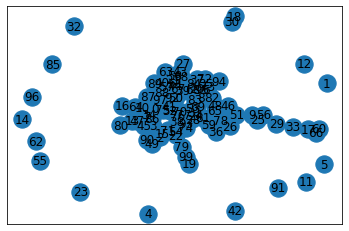

{"type":"reset"}
Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


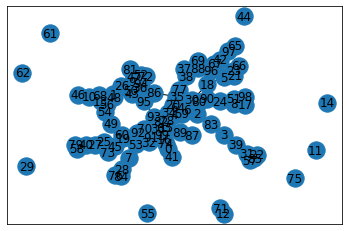

{"type":"reset"}
Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


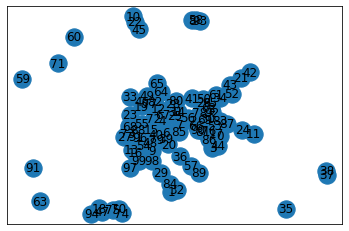

{"type":"reset"}
Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


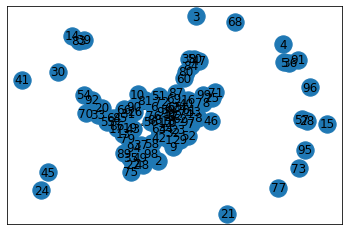

{"type":"reset"}
Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


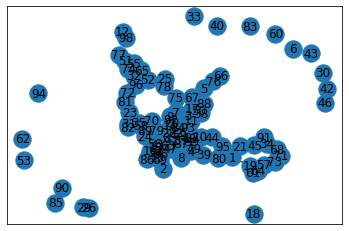

{"type":"reset"}
Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


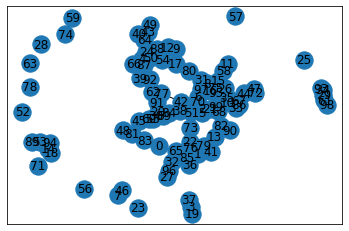

{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step":32}
{"type":"get_step","step":33}
{"type":"get_step",

{"type":"get_step","step":269}
{"type":"get_step","step":270}
{"type":"get_step","step":271}
{"type":"get_step","step":272}
{"type":"get_step","step":273}
{"type":"get_step","step":274}
{"type":"get_step","step":275}
{"type":"get_step","step":276}
{"type":"get_step","step":277}
{"type":"get_step","step":278}
{"type":"get_step","step":279}
{"type":"get_step","step":280}
{"type":"get_step","step":281}
{"type":"get_step","step":282}
{"type":"get_step","step":283}
{"type":"get_step","step":284}
{"type":"get_step","step":285}
{"type":"get_step","step":286}
{"type":"get_step","step":287}
{"type":"get_step","step":288}
{"type":"get_step","step":289}
{"type":"get_step","step":290}
{"type":"get_step","step":291}
{"type":"get_step","step":292}
{"type":"get_step","step":293}
{"type":"get_step","step":294}
{"type":"get_step","step":295}
{"type":"get_step","step":296}
{"type":"get_step","step":297}
{"type":"get_step","step":298}
{"type":"get_step","step":299}
{"type":"get_step","step":300}
{"type":

{"type":"get_step","step":534}
{"type":"get_step","step":535}
{"type":"get_step","step":536}
{"type":"get_step","step":537}
{"type":"get_step","step":538}
{"type":"get_step","step":539}
{"type":"get_step","step":540}
{"type":"get_step","step":541}
{"type":"get_step","step":542}
{"type":"get_step","step":543}
{"type":"get_step","step":544}
{"type":"get_step","step":545}
{"type":"get_step","step":546}
{"type":"get_step","step":547}
{"type":"get_step","step":548}
{"type":"get_step","step":549}
{"type":"get_step","step":550}
{"type":"get_step","step":551}
{"type":"get_step","step":552}
{"type":"get_step","step":553}
{"type":"get_step","step":554}
{"type":"get_step","step":555}
{"type":"get_step","step":556}
{"type":"get_step","step":557}
{"type":"get_step","step":558}
{"type":"get_step","step":559}
{"type":"get_step","step":560}
{"type":"get_step","step":561}
{"type":"get_step","step":562}
{"type":"get_step","step":563}
{"type":"get_step","step":564}
{"type":"get_step","step":565}
{"type":

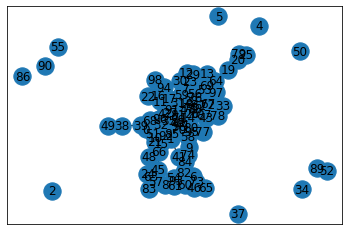

{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step":32}
{"type":"get_step","step":33}
{"type":"get_step",

{"type":"get_step","step":269}
{"type":"get_step","step":270}
{"type":"get_step","step":271}
{"type":"get_step","step":272}
{"type":"get_step","step":273}
{"type":"get_step","step":274}
{"type":"get_step","step":275}
{"type":"get_step","step":276}
{"type":"get_step","step":277}
{"type":"get_step","step":278}
{"type":"get_step","step":279}
{"type":"get_step","step":280}
{"type":"get_step","step":281}
{"type":"get_step","step":282}
{"type":"get_step","step":283}
{"type":"get_step","step":284}
{"type":"get_step","step":285}
{"type":"get_step","step":286}
{"type":"get_step","step":287}
{"type":"get_step","step":288}
{"type":"get_step","step":289}
{"type":"get_step","step":290}
{"type":"get_step","step":291}
{"type":"get_step","step":292}
{"type":"get_step","step":293}
{"type":"get_step","step":294}
{"type":"get_step","step":295}
{"type":"get_step","step":296}
{"type":"get_step","step":297}
{"type":"get_step","step":298}
{"type":"get_step","step":299}
{"type":"get_step","step":300}
{"type":

{"type":"get_step","step":534}
{"type":"get_step","step":535}
{"type":"get_step","step":536}
{"type":"get_step","step":537}
{"type":"get_step","step":538}
{"type":"get_step","step":539}
{"type":"get_step","step":540}
{"type":"get_step","step":541}
{"type":"get_step","step":542}
{"type":"get_step","step":543}
{"type":"get_step","step":544}
{"type":"get_step","step":545}
{"type":"get_step","step":546}
{"type":"get_step","step":547}
{"type":"get_step","step":548}
{"type":"get_step","step":549}
{"type":"get_step","step":550}
{"type":"get_step","step":551}
{"type":"get_step","step":552}
{"type":"get_step","step":553}
{"type":"get_step","step":554}
{"type":"get_step","step":555}
{"type":"get_step","step":556}
{"type":"get_step","step":557}
{"type":"get_step","step":558}
{"type":"get_step","step":559}
{"type":"get_step","step":560}
{"type":"get_step","step":561}
{"type":"get_step","step":562}
{"type":"get_step","step":563}
{"type":"get_step","step":564}
{"type":"get_step","step":565}
{"type":

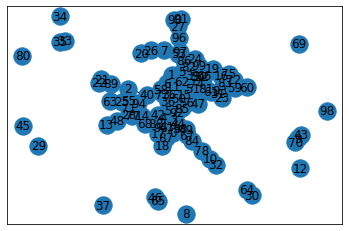

{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step":32}
{"type":"get_step","step":33}
{"type":"get_step",

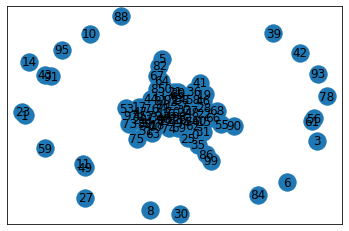

{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step":32}
{"type":"get_step","step":33}
{"type":"get_step",

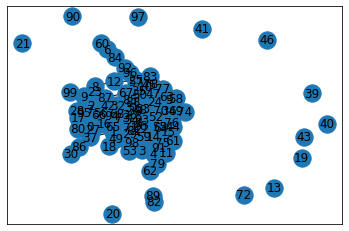

{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step":32}
{"type":"get_step","step":33}
{"type":"get_step",

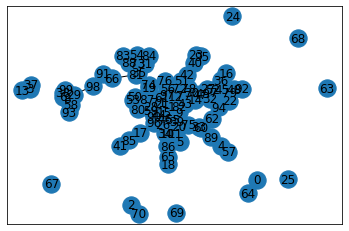

In [10]:
# launch server
server.launch()

# datacollection.py

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


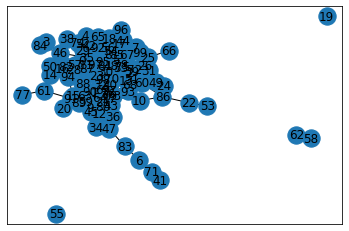

In [23]:
# run the model 2000 steps with 100 agents
model100 = SEmodel(100)
for i in range(2000):
    model100.step()

(array([ 6.,  3.,  9., 27., 22., 15.,  7.,  6.,  4.,  1.]),
 array([0.     , 0.20092, 0.40184, 0.60276, 0.80368, 1.0046 , 1.20552,
        1.40644, 1.60736, 1.80828, 2.0092 ]),
 <BarContainer object of 10 artists>)

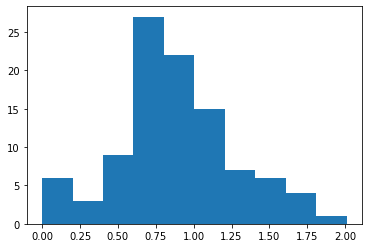

In [12]:
# plot agents' opinion distribution over the whole network
agents_opinion = [a.opinion for a in model100.schedule.agents]
plt.hist(agents_opinion)

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


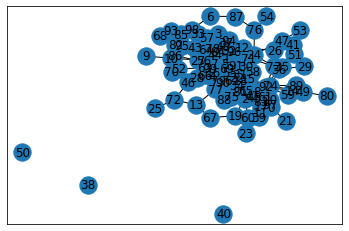

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


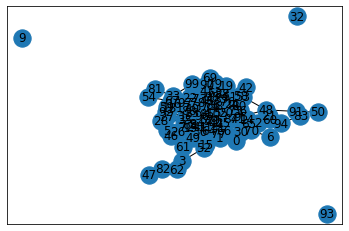

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


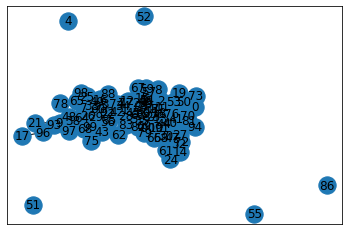

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


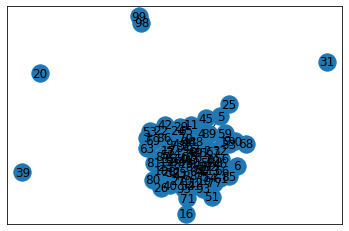

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


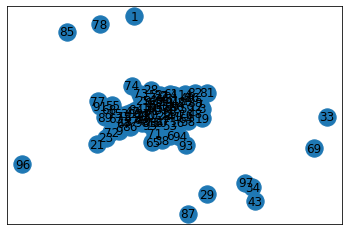

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


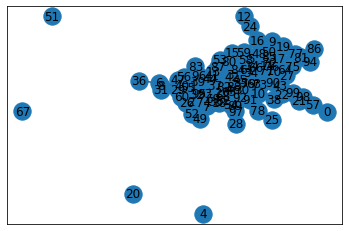

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


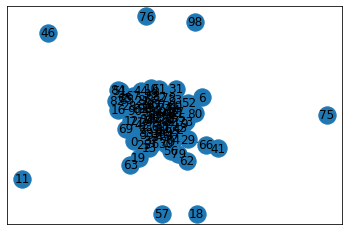

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


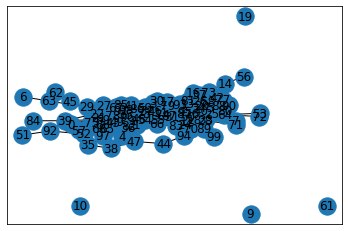

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


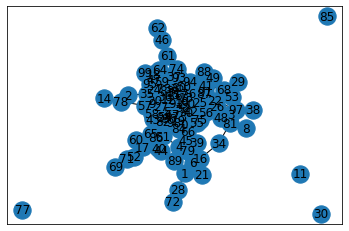

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


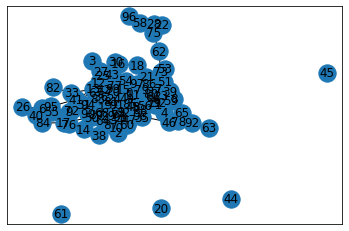

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


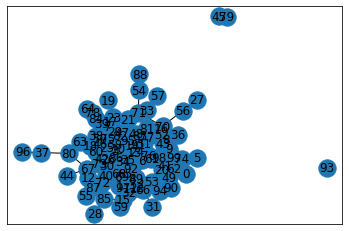

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


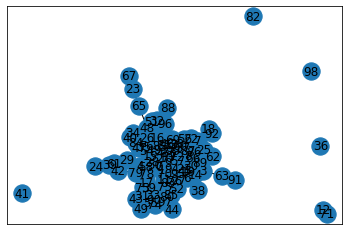

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


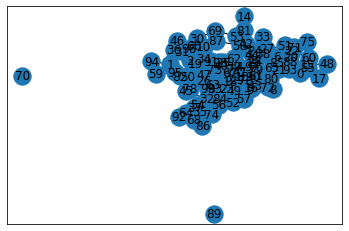

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


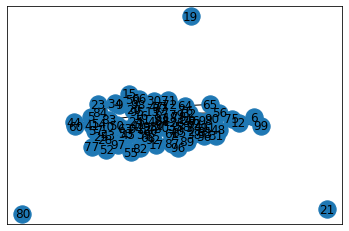

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


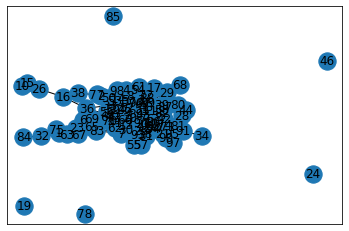

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


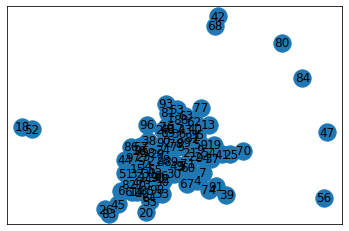

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


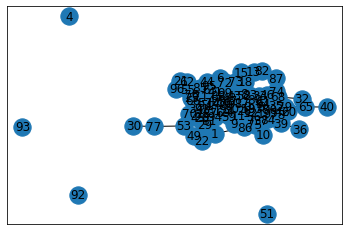

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


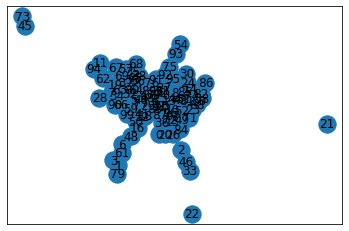

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


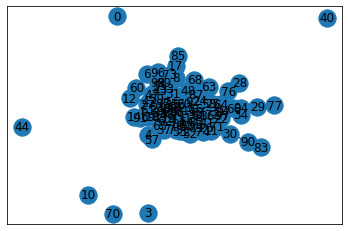

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


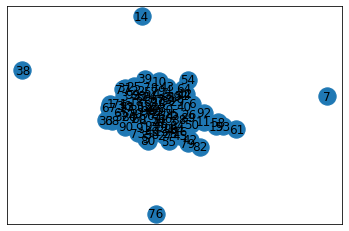

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


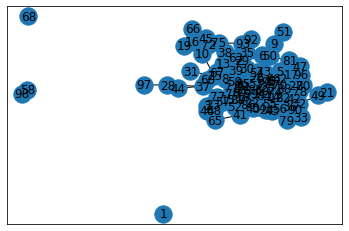

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


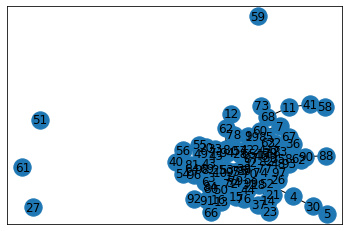

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


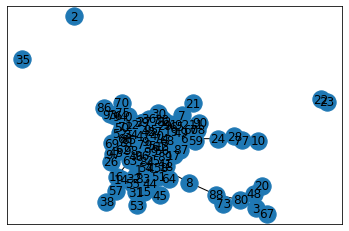

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


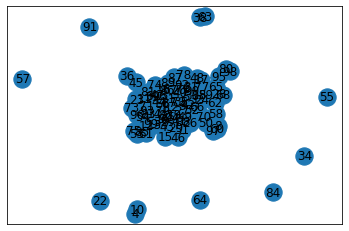

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


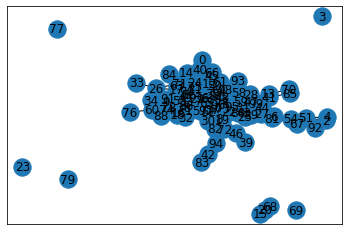

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


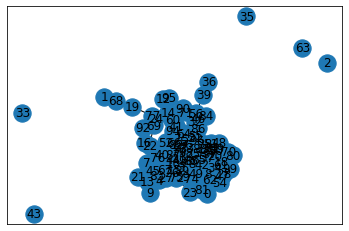

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


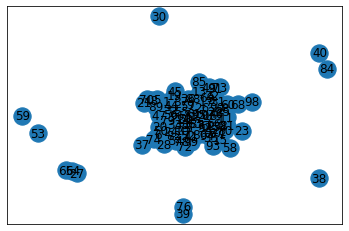

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


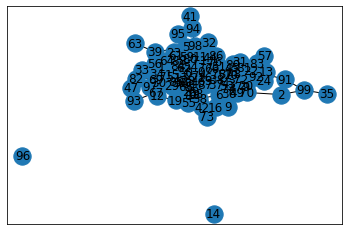

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


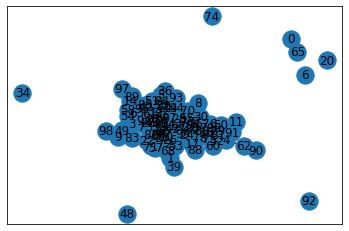

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


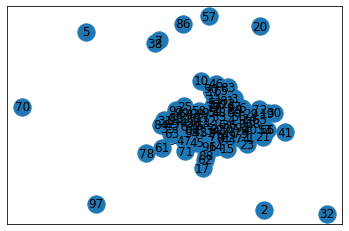

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


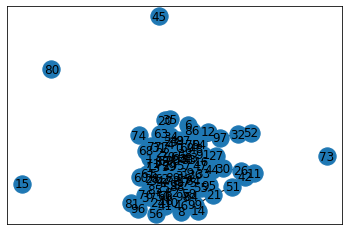

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


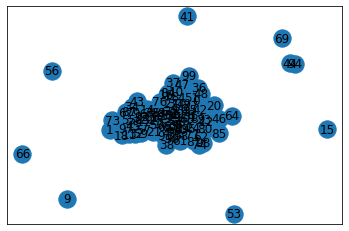

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


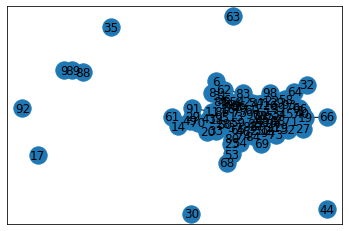

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


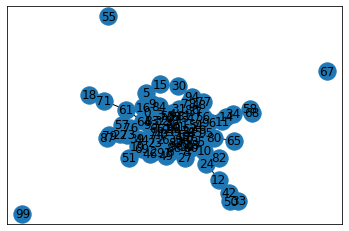

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


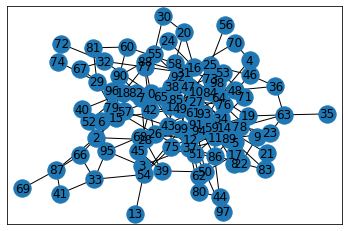

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


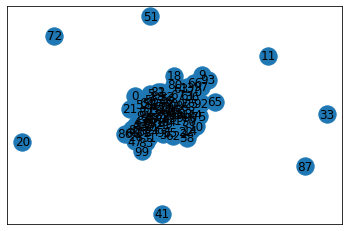

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


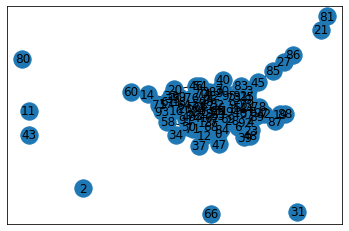

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


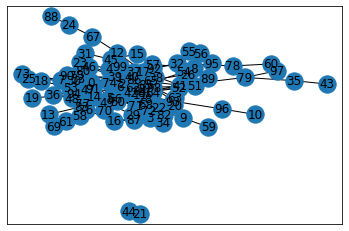

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


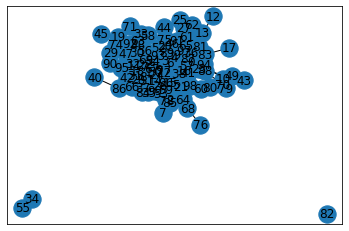

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


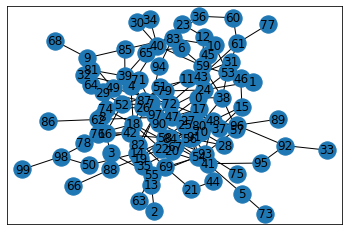

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


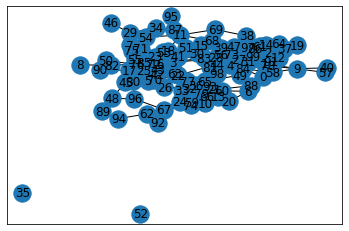

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


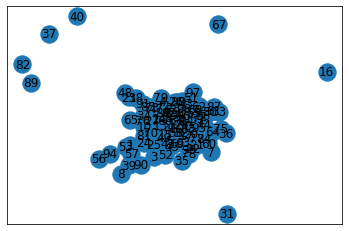

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


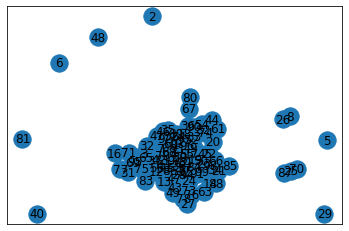

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


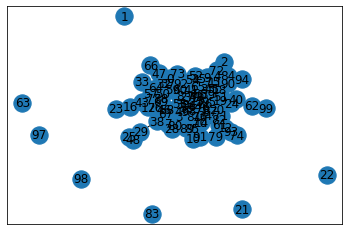

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


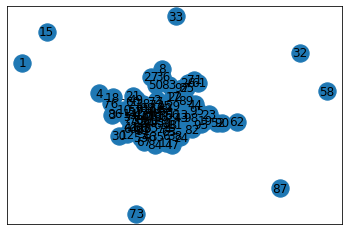

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


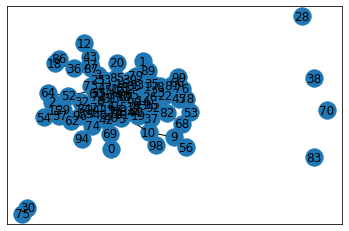

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


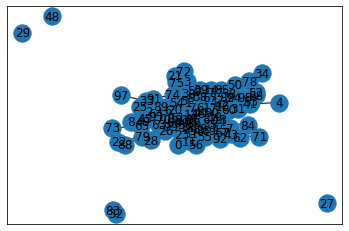

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


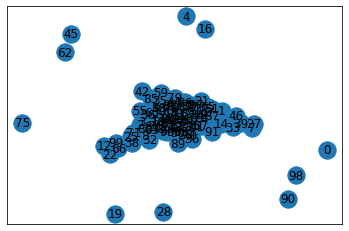

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


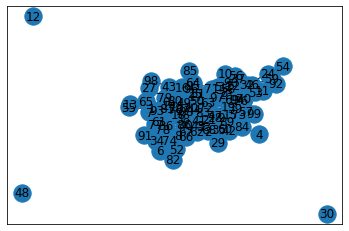

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


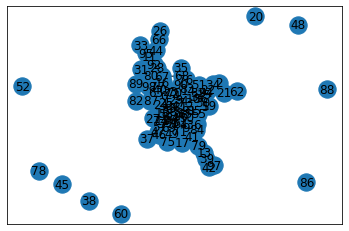

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


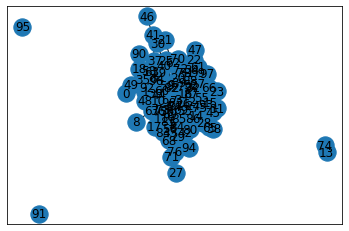

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


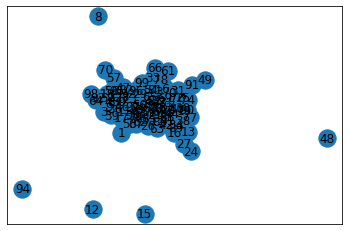

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


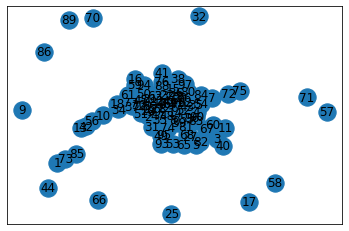

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


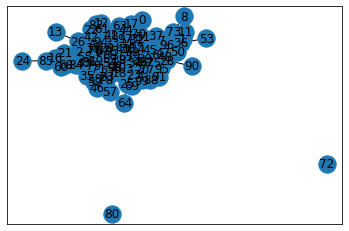

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


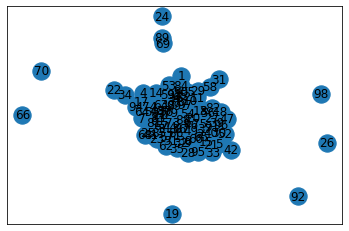

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


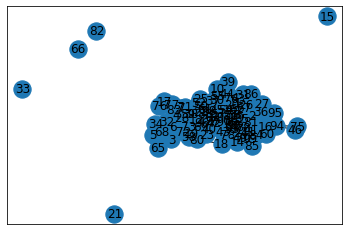

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


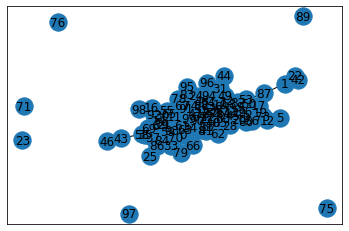

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


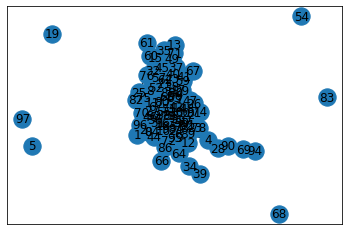

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


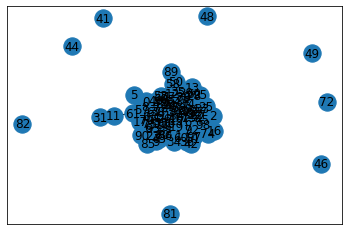

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


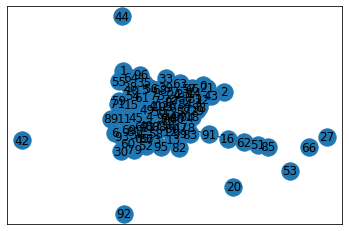

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


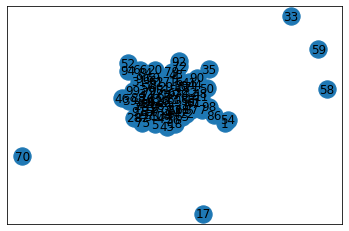

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


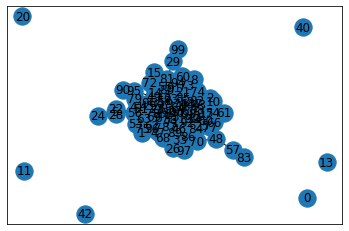

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


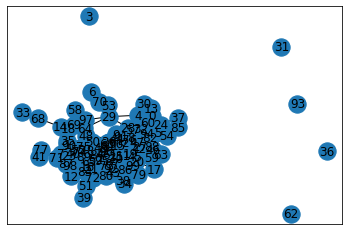

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


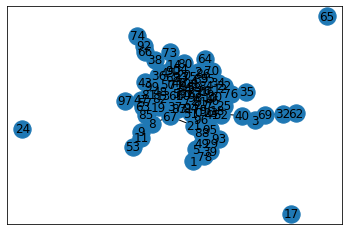

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


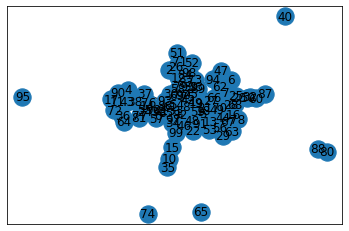

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


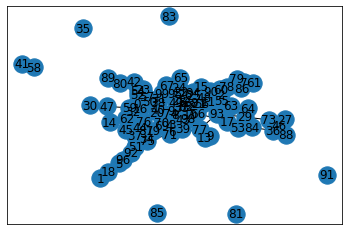

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


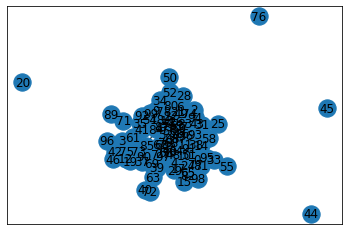

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


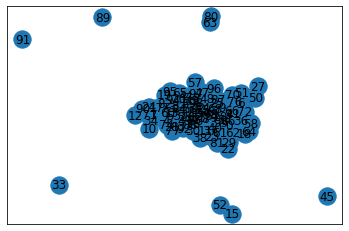

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


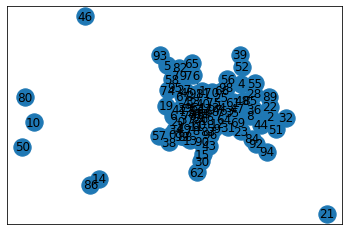

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


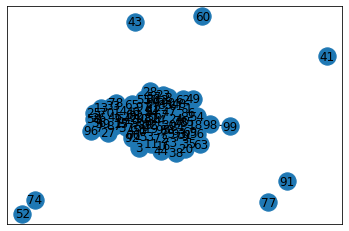

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


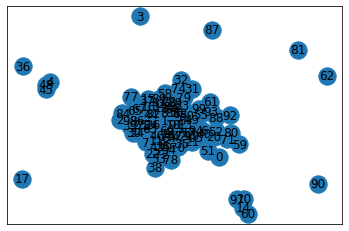

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


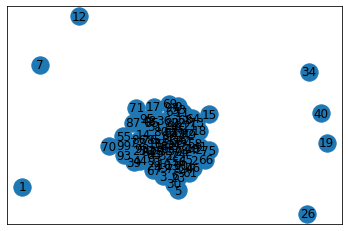

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


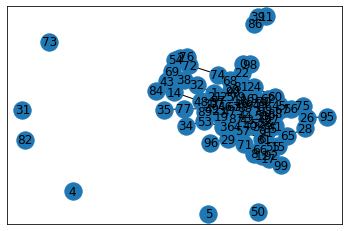

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


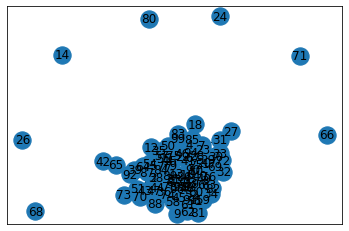

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


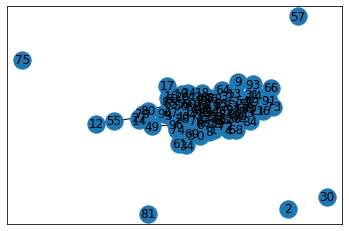

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


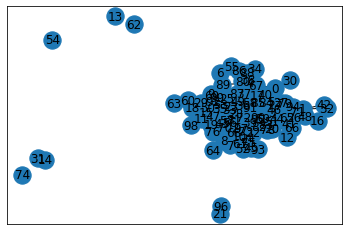

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


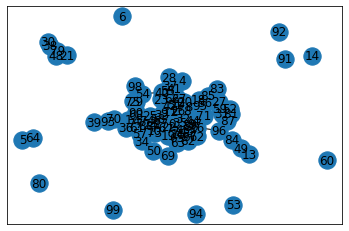

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


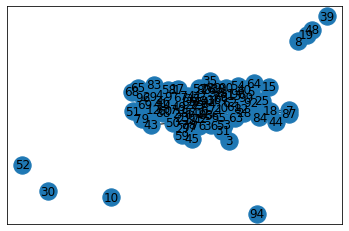

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


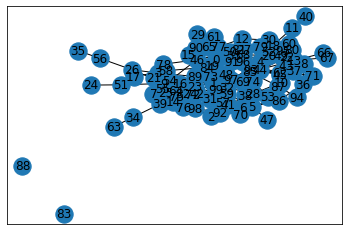

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


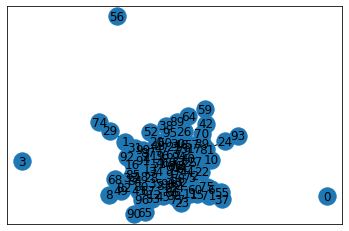

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


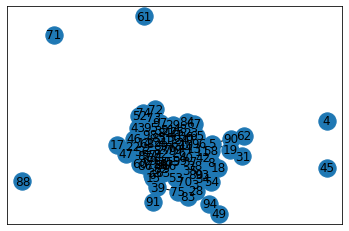

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


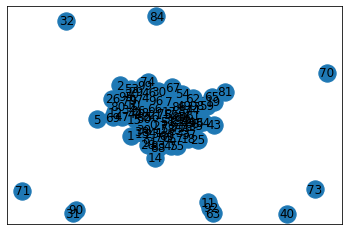

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


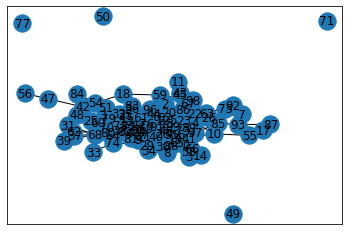

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


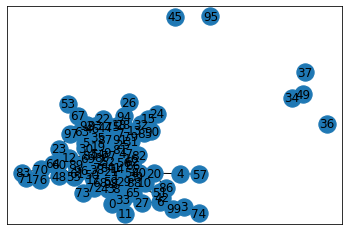

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


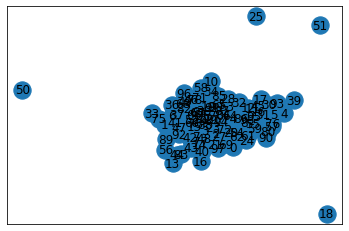

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


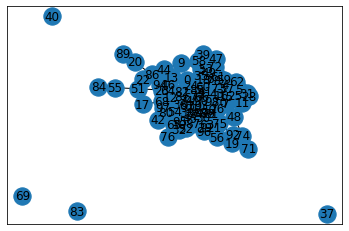

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


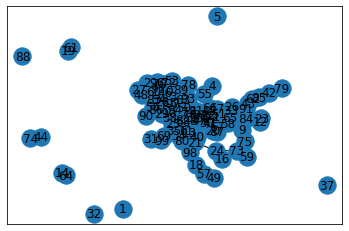

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


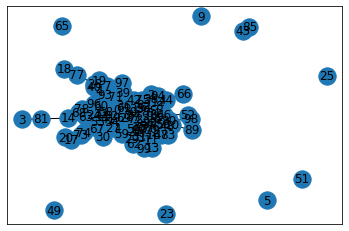

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


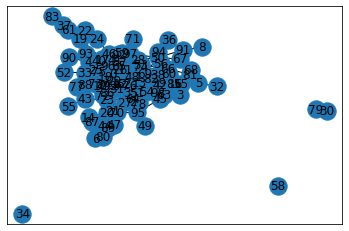

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


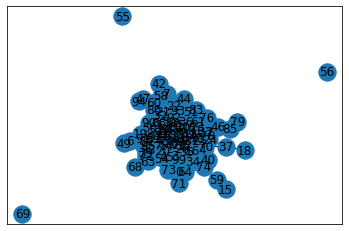

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


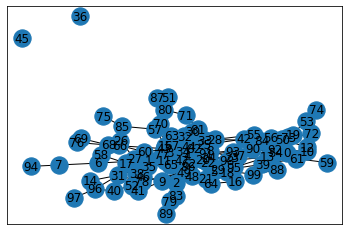

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


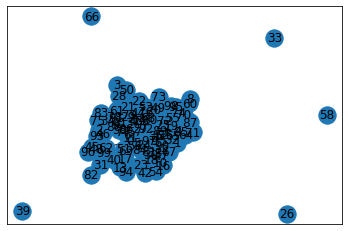

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


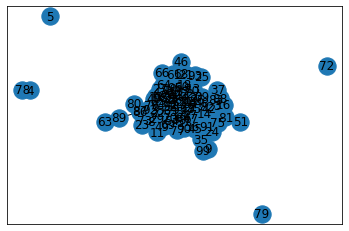

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


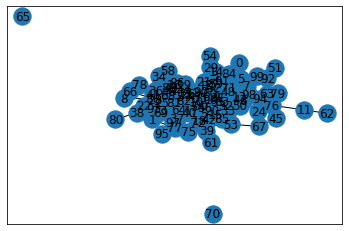

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


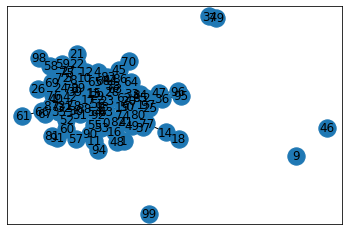

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


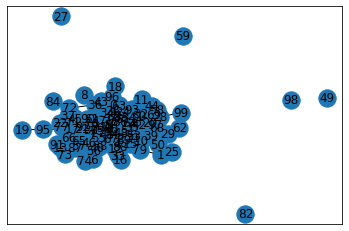

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


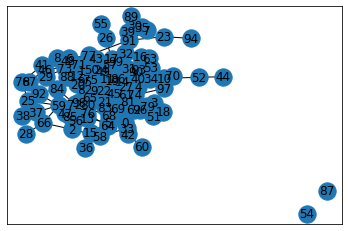

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


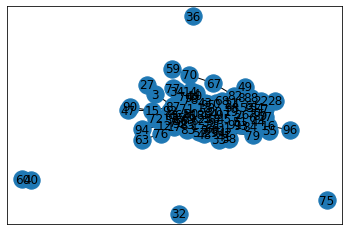

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


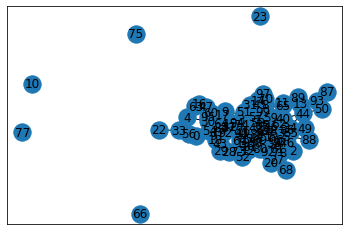

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


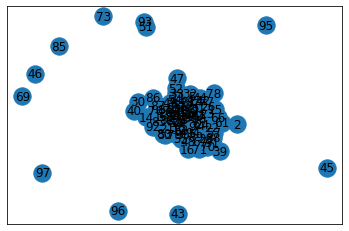

(array([5985.]), array([0, 1]), <BarContainer object of 1 artists>)

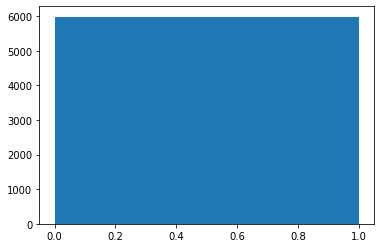

In [15]:
# run the model 100 times and check for the distribution of overall opinion
all_opinion = []
for j in range(100):
    model100 = SEmodel(100)
    for i in range(2000):
        model100.step()
        
    # store the results
    for agent in model100.schedule.agents:
        all_opinion.append(agent.opinion)

plt.hist(all_opinion, bins=range(5))

In [16]:
# get the model variables in a dataframe
model_vars = model100.datacollector.get_model_vars_dataframe()
model_vars.head

<bound method NDFrame.head of       Negative  Neutral  Positive  Total Engagement  Total Trustability  \
0            3       94         3           49.4900               21.69   
1            3       94         3           49.8190               21.69   
2            3       94         3           50.1480               21.69   
3            3       94         3           50.4770               21.69   
4            3       94         3           50.8060               21.69   
...        ...      ...       ...               ...                 ...   
1996        79       14         7          874.4613               20.08   
1997        77       17         6          874.5062               20.08   
1998        77       16         7          874.5417               20.08   
1999        77       17         6          874.5678               20.08   
2000        78       15         7          874.6033               20.08   

      Total Recovery  Total Experience  
0               63.8        

<AxesSubplot:>

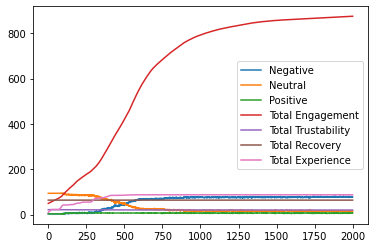

In [18]:
# plot a series of the data collected on the model
model_vars.plot()
# I should normalise engagement variable

In [24]:
# get the agent variables in a dataframe
agent_vars = model100.datacollector.get_agent_vars_dataframe()
agent_vars

Opinion  Engagement  Trustability  Recovery  Experience
Step AgentID                                                          
0    0        0.000000        0.49          0.21      0.63         0.1
     1        1.000000        0.75          0.49      0.73         0.1
     2        0.000000        0.49          0.21      0.63         0.1
     3        0.000000        0.49          0.21      0.63         0.1
     4        0.000000        0.49          0.21      0.63         0.1
...                ...         ...           ...       ...         ...
2000 95       0.630000       10.00          0.21      0.63         1.0
     96       0.428607       10.00          0.21      0.63         1.0
     97       0.630000       10.00          0.21      0.63         1.0
     98       1.260000       10.00          0.21      0.63         1.0
     99       0.970000       10.00          0.21      0.63         1.0

[200100 rows x 5 columns]

<AxesSubplot:>

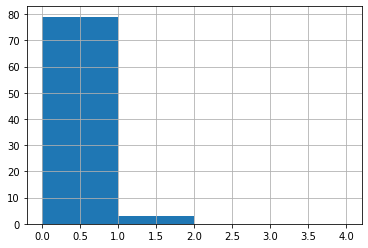

In [30]:
# plot an histogram of agent opinion
end_opinion = agent_vars.xs(99, level='Step')['Opinion']
end_opinion.hist(bins=range(5))

<AxesSubplot:xlabel='Step'>

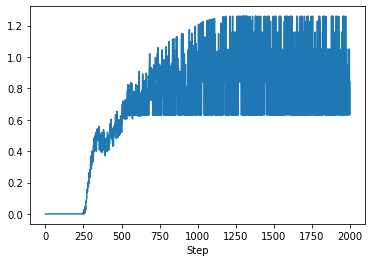

In [29]:
# get the opinion of a random agent
one_agent_opinion = agent_vars.xs(random.randint(1, 100), level='AgentID')
one_agent_opinion.Opinion.plot()

# batchrun.py

0it [00:00, ?it/s]

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


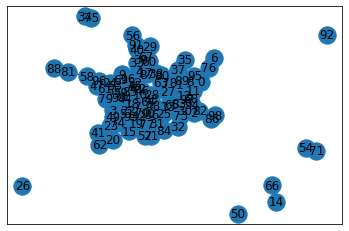

1it [00:05,  5.53s/it]

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


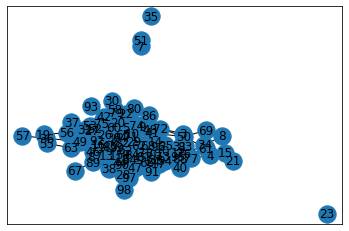

2it [00:11,  5.92s/it]

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


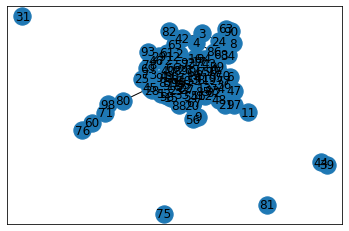

3it [00:17,  6.03s/it]

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


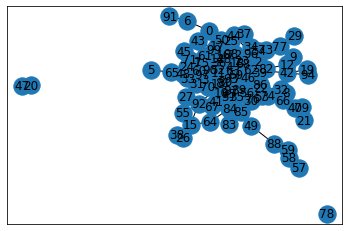

4it [00:23,  6.00s/it]

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


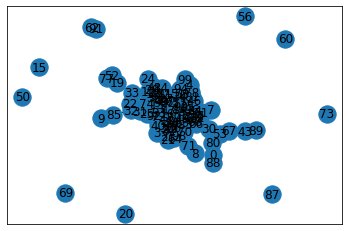

5it [00:29,  5.88s/it]

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


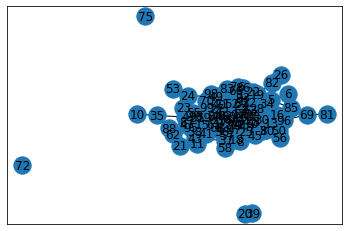

6it [00:35,  5.89s/it]

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


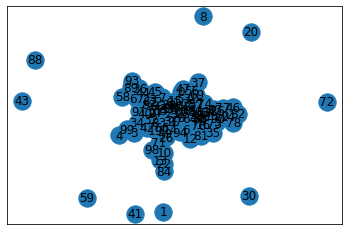

7it [00:40,  5.70s/it]

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


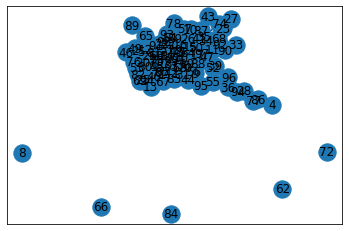

8it [00:46,  5.84s/it]

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


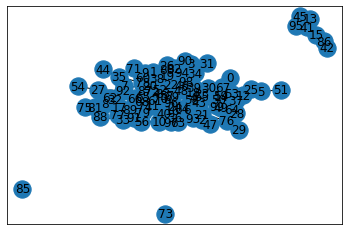

9it [00:52,  5.76s/it]

Finished initialising model, network has [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] nodes


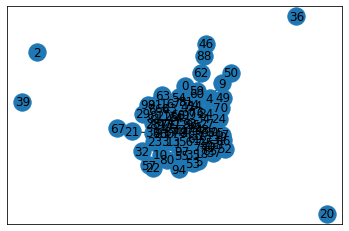

10it [00:58,  5.85s/it]


In [32]:
# batch run consists in running the model multiple times and varying parameters
# e.g. test the influence of initial opinion of the population on final result
fixed_params = {'num_nodes': 100,
                'avg_node_degree': 3}

variable_params = {'initial_opinion': range(-1, 1, 1)}

batch_run = BatchRunner(SEmodel,
                       variable_params,
                       fixed_params,
                       iterations=5,
                       max_steps=2000,
                       model_reporters={"Negative": num_negative,
                                        "Neutral": num_neutral,
                                        "Positive": num_positive})
batch_run.run_all()

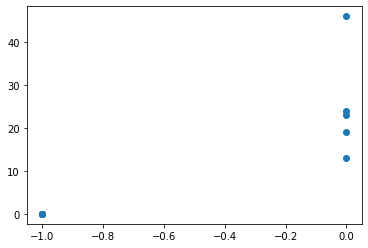

In [37]:
# plot data collected via batch runner
batch_data = batch_run.get_model_vars_dataframe()
batch_data.head()
plt.scatter(batch_data.initial_opinion, 
            batch_data.Neutral)

In [39]:
# get the agent datacollection
batch_agents = batch_run.get_collector_agents()
batch_agents

OrderedDict([((-1, 0),
                            Opinion  Engagement  Trustability  Recovery  Experience
              Step AgentID                                                         
              0    0          -1.00        0.49          0.21      0.63         0.1
                   1          -1.00        0.49          0.21      0.63         0.1
                   2          -1.00        0.49          0.21      0.63         0.1
                   3           1.00        0.69          0.29      0.97         0.1
                   4          -1.00        0.49          0.21      0.63         0.1
              ...               ...         ...           ...       ...         ...
              2000 95         -1.21       10.00          0.21      0.63         0.1
                   96         -1.00        9.89          0.21      0.63         0.1
                   97         -1.83       10.00          0.21      0.63         0.1
                   98         -1.20        7.49      